In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/02_outlet.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config['domain']

{'adjustParticle': False, 'adjustDomain': False, 'dim': 2, 'periodic': True}

In [4]:
nx = 256
L = 1
u_mag = 5
k = 1 * np.pi
TGV_override = False
targetRe = 1000

config['domain']['minExtent'] = [-2.2,-1.2]
config['domain']['maxExtent'] =  [2.2,1.2]
config['domain']['periodic'] = False

config['boundary']['active'] = True

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 1000.0, $\nu_{sph} = 0.009999999776482582$, $\alpha = 0.035979680716991425$


In [5]:
config['particle']['support'] * 2

tensor(0.0712)

In [6]:
# from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

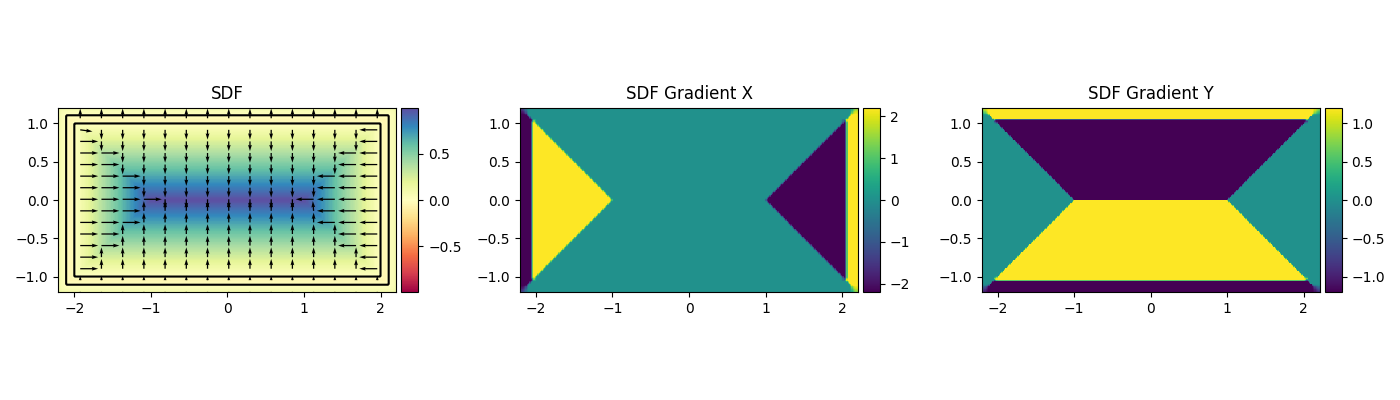

In [7]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('polygon')['function'](points, torch.tensor([[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[-0.5,0.5]]))
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 3,1 + config['particle']['support'] * 3]).to(points.device))


translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)

outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
sdf = operatorDict['invert'](sdf)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sdf
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [8]:
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour
# from diffSPH.v2.modules.divergence import computeDivergence

# def find_contour(f, minExtent, maxExtent, nGrid, level = 0):
#     contours = measure.find_contours(f.numpy(), level)
#     for ic in range(len(contours)):
#         contours[ic][:,0] = (contours[ic][:,0]) / (f.shape[0] - 1) * (maxExtent[0] - minExtent[0]).numpy() + minExtent[0].numpy()
#         contours[ic][:,1] = (contours[ic][:,1]) / (f.shape[0] - 1) * (maxExtent[1] - minExtent[1]).numpy() + minExtent[1].numpy()
#     return contours

In [9]:
ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 2,1 + config['particle']['support'] * 2]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](sdf)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1/2]).to(points.device))
fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    {
        'sdf': boundary_sdf,
        'type': 'boundary',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
        'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [10]:


# # sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1]).to(points.device))
# # outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# # fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

# print(outletSDF(torch.clone(points)).min())
# plotSDF(outletSDF(torch.clone(points),), X, Y, 2, 2)

In [11]:
from diffSPH.v2.plotting import setPlotBaseAttributes

# fig, axis = plt.subplots(1, 2, figsize = (14,5), squeeze = False)

# setPlotBaseAttributes(axis[0,0], config)
# setPlotBaseAttributes(axis[0,1], config)

# # def plotRegions(regions, axis):
# #     for region in regions:
# #         # visualizeParticles(region['particles'], axis[0,0], config)
# #         for ic, contour in enumerate(region['contour']):
# #             color = 'black'
# #             style = '-'
# #             if region['type'] == 'inlet':
# #                 color = 'green'
# #                 style = '--'
# #             if region['type'] == 'forcing':
# #                 color = 'blue'
# #                 style = ':'
# #             if region['type'] == 'outlet':
# #                 color = 'red'
# #                 style = ':'
# #             if region['type'] == 'mirror':
# #                 color = 'black'
# #                 style = ':'
# #             # axis[0,0].plot(contour[:,0], contour[:,1], color=color)
# #             axis.plot(contour[:,0], contour[:,1], color = color, ls = style, label = region['type'] if ic == 0 else None)
# #         if region['type'] == 'inlet':
# #             axis.scatter(region['particles']['positions'][:,0].detach().cpu().numpy(), region['particles']['positions'][:,1].detach().cpu().numpy(), color = 'green', s = 1)
#     # axis[0,0].legend()

# plotRegions(regions, axis[0,0])
# fig.tight_layout()

#     # axis[0,0].contour(X.numpy(), Y.numpy(), fx.numpy(), levels=[0], colors='black')

In [12]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict
from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid, visualizeParticleQuantity

# particleState, mask = sampleParticles(config, sdfs = [sdf])

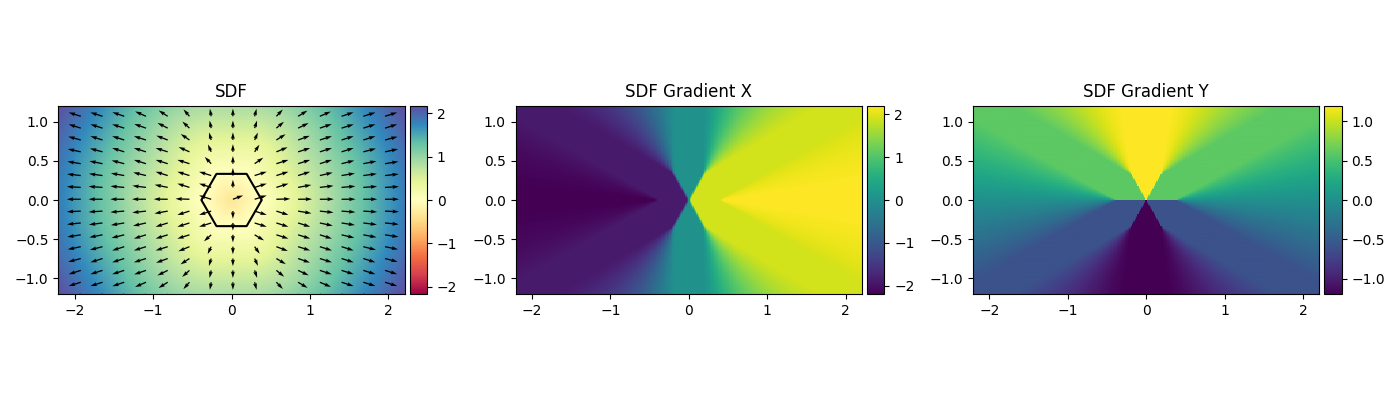

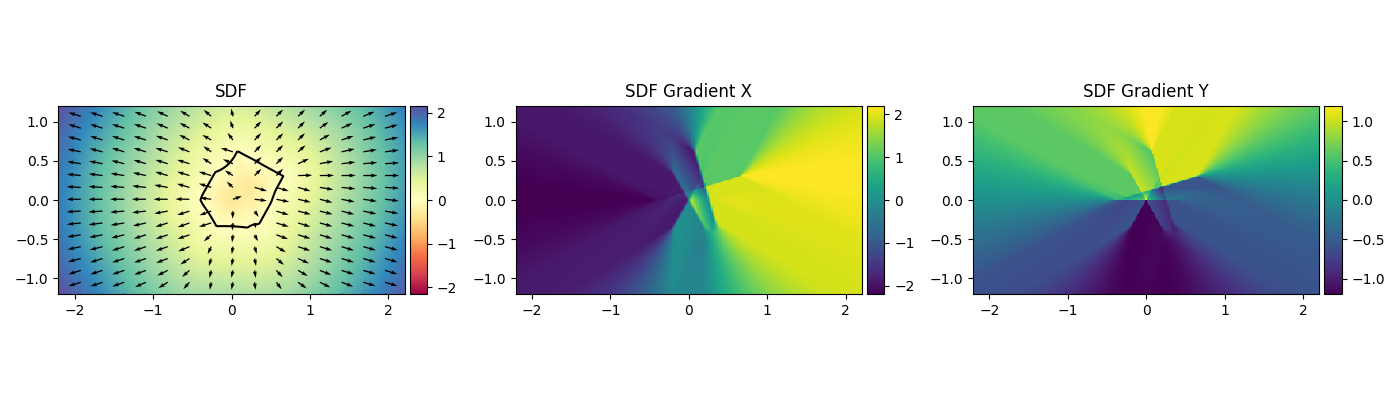

In [13]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 1/3)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
fluid_sdf = sphere_a
plotSDF(fluid_sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([2,1/8]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.0,-1/2 - 1/8]))
boundary_sdf = sdf
plotSDF(boundary_sdf(torch.clone(points),), X, Y, 2, 2)

In [14]:
print(config['gravity'])
config['gravity']['active'] = True
display(config['EOS'])
config['EOS']['type'] = 'stiffTait'

{'active': False, 'direction': [0, -1, 0], 'magnitude': 9.81, 'gravityMode': 'constant', 'potentialOrigin': [0, 0, 0]}


{'gasConstant': 8.14,
 'molarMass': 0.02897,
 'polytropicExponent': 7,
 'kappa': 1.3,
 'type': 'isoThermal'}

In [15]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs



# particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'inlet'])
particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'fluid'])

# sdf = 
boundaryState = processBoundarySDFs(particleState, config, [region['sdf'] for region in regions if region['type'] == 'boundary'], 'regular')

In [16]:
config['timestep']['dt'] = 1e-4
s = 2
perennialState = {
    'fluid': copy.deepcopy(particleState),
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1
# perennialState['fluid']['velocities'][:,0] = u

In [17]:
perennialState['fluid']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)
perennialState['boundary']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['boundary']['numParticles'], 2], device = perennialState['boundary']['positions'].device)

In [18]:
config['simulation']

{'correctArea': False,
 'supportScheme': 'symmetric',
 'densityScheme': 'continuity',
 'timestamp': '2024_06_07-14_51_02'}

In [19]:
from diffSPH.v2.simulationSchemes.deltaPlus import callModule
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates, LiuLiuConsistent
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices
from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles, mDBCDensity


def simulationStep(state, config):
    with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
        searchNeighbors(state, config)
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (2 - Ghost Particle Creation)"):
        state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
        state['outletGhost'] = buildOutletGhostParticles(regions, state, config)
        # torch.cuda.synchronize()
        
    with record_function("[SPH] - deltaSPH (3 - Density Computation)"):
        if config['simulation']['densityScheme'] == 'summation':
            if config['boundary']['active']:
                state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
            else:
                state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
            torch.cuda.synchronize()
        if config['boundary']['active']:
            with record_function("[SPH] - deltaSPH (3 - mDBC Density Estimate)"):
                state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
                # torch.cuda.synchronize()

    if state['outletGhost'] is not None:
        with record_function("[SPH] - deltaSPH (4 - Outlet Processing)"):
            ghostState = state['outletGhost']
            neighbors = ghostState['neighborhood']['indices'][0]
            solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

            cond = torch.logical_and(ghostState['numNeighbors'] >= 10, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
            cond = ghostState['numNeighbors'] >= 10

            def updateQuantity(state, ghostState, quantity, solution, cond):
                return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
            state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
            
            solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
            state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

            
            solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
            state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)
            
            # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (5 - Normalization Matrices)"):
        state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluid')
        state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (6 - Density Gradient)"):
        state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
        if config['boundary']['active']:
            state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]
        # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (7 - Diffusion and Momentum)"):
        state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
        # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        # torch.cuda.synchronize()
        if config['boundary']['active']:
            # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
            state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')

            state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
        else:
            state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')

            state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
        # torch.cuda.synchronize()
        state['fluid']['pressures'] = computeEOS(state['fluid'], config)

        if 'boundary' in state:
            state['boundary']['pressures'] = computeEOS(state['boundary'], config)

    with record_function("[SPH] - deltaSPH (8 - Pressure Forces)"):
        if 'boundary' in state:
            state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
        else:
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
        # torch.cuda.synchronize()
    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')

    with record_function("[SPH] - deltaSPH (9 - External Forcing)"):
        state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)
        # torch.cuda.synchronize()

    # if config['SPS']['active']:
    #     with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #         state['fluid']['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
    # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (10 - Integration)"):
        dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
        drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

        if state['outletGhost'] is not None:
            dudt[ghostState['fluidIndex'],:] = 0
            drhodt[ghostState['fluidIndex']] = 0

        if 'boundary' not in state:
            return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
        # torch.cuda.synchronize()   
        boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
        boundary_drhodt = state['boundary']['momentumEquation'] *0

        return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]


from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    # for i in tqdm(range(8)):
        # with record_function("timing"): 
curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            # dx, _ = solveShifting(curState, config)
            # curState['fluid']['shiftAmount'] = dx
            # curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
# print(prof.key_averages().table(sort_by='cpu_time_total'))


# prof.export_chrome_trace("trace.json")

In [20]:

curState = copy.deepcopy(perennialState)
searchNeighbors(curState, config)
curState['boundaryGhost'] = buildBoundaryGhostParticles(curState, config)

In [31]:
curState['boundaryGhost']['masses'].shape

torch.Size([9184])

In [30]:

neighborOffsets = curState['boundaryGhost']['neighborhood']['neighborOffsets']

In [21]:
masses = (curState['boundaryGhost']['masses'], curState['fluid']['masses']) 
densities = (curState['boundaryGhost']['densities'], curState['fluid']['densities'])
velocities = (curState['boundaryGhost']['velocities'], curState['fluid']['velocities'])

neighborhood = curState['boundaryGhost']['neighborhood']['indices']
kernels = curState['boundaryGhost']['neighborhood']['kernels']
kernelGradients = curState['boundaryGhost']['neighborhood']['gradients']
radialDistances = curState['boundaryGhost']['neighborhood']['distances']
directions = curState['boundaryGhost']['neighborhood']['vectors']
supports = curState['boundaryGhost']['neighborhood']['supports']

numParticles = (curState['boundaryGhost']['numParticles'], curState['fluid']['numParticles'])
numNeighbors = curState['boundaryGhost']['numNeighbors']

boundaryPositions = (curState['boundary']['positions'], curState['boundaryGhost']['positions'])

neighborOffsets = curState['boundaryGhost']['neighborhood']['neighborOffsets']


In [22]:
import torch
from diffSPH.v2.math import scatter_sum
from typing import Dict, Optional, Union
from torch.profiler import record_function

from typing import Tuple, Optional
# @torch.jit.script
def broadcast_nj(src: torch.Tensor, other: torch.Tensor, dim: int):
    if dim < 0:
        dim = other.dim() + dim
    if src.dim() == 1:
        for _ in range(0, dim):
            src = src.unsqueeze(0)
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand(other.size())
    return src

# @torch.jit.script
def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast_nj(index, src, dim)
    if out is None:
        size = list(src.size())
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)

# @torch.jit.script 
def sphInterpolation(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int):                                                        # Ancillary information
    j = neighborhood[1]
    k = masses[1][j] / densities[1][j] * kernels
    kq = torch.einsum('n..., n -> n...', quantities[1][j] if isinstance(quantities,tuple) else quantities, k)
    
    return scatter_sum(kq, neighborhood[0], dim = 0, dim_size = numParticles)

# @torch.jit.script 
def sphDensityInterpolation(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int):                                                        # Ancillary information
    j = neighborhood[1]
    kq = masses[1][j] * kernels
    
    return scatter_sum(kq, neighborhood[0], dim = 0, dim_size = numParticles)


# @torch.jit.script 
def sphGradient(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int, type : str = 'naive'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]
    if type == 'symmetric':
        assert isinstance(quantities, tuple), 'Symmetric gradient only supports two inputs for quantities!'
        k = masses[1][j].view(-1,1) * gradKernels
        Ai = torch.einsum('n..., n -> n...', quantities[0][i], 1.0 / densities[0][i]**2)
        Aj = torch.einsum('n..., n -> n...', quantities[1][j], 1.0 / densities[1][j]**2)
        kq = torch.einsum('n... , nd -> n...d', Ai + Aj, k)

        return torch.einsum('n, n... -> n...', densities[0], scatter_sum(kq, i, dim = 0, dim_size = numParticles))
    elif type == 'difference':
        k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
        qij = (quantities[0][i] - quantities[1][j]) if isinstance(quantities, tuple) else quantities
        kq = torch.einsum('n... , nd -> n...d', qij, k)
    elif type == 'summation':
        k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
        qij = (quantities[0][i] + quantities[1][j]) if isinstance(quantities, tuple) else quantities
        kq = torch.einsum('n... , nd -> n...d', qij, k)
    else:
        k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
        qij = (quantities[1][j]) if isinstance(quantities, tuple) else quantities
        kq = torch.einsum('n... , nd -> n...d', qij, k)
    
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)


# @torch.jit.script 
def sphDivergence(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int, type : str = 'naive', mode : str = 'div'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]

    assert (isinstance(quantities, tuple) and quantities[0].dim() > 1) or (isinstance(quantities, torch.Tensor) and quantities.dim() > 1), 'Cannot compute divergence on non vector fields!'
    assert (mode in ['div','dot']), 'Only supports div F and nabla dot F'

    if type == 'symmetric':
        assert isinstance(quantities, tuple), 'Symmetric divergence only supports two inputs for quantities!'
        k = masses[1][j].view(-1,1) * gradKernels
        Ai = torch.einsum('n..., n -> n...', quantities[0][i], 1.0 / densities[0][i]**2)
        Aj = torch.einsum('n..., n -> n...', quantities[1][j], 1.0 / densities[1][j]**2)
        q = Ai + Aj
            
        if mode == 'div':
            kq = torch.einsum('n...d, nd -> n...', q, k)
        else:
            kq = torch.einsum('nd..., nd -> n...', q, k)

        return torch.einsum('n, n... -> n...', densities[0], scatter_sum(kq, i, dim = 0, dim_size = numParticles))
        
    q = quantities[1][j] if isinstance(quantities, tuple) else quantities
    k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
    
    if type == 'difference':
        q = (quantities[1][j] - quantities[0][i]) if isinstance(quantities, tuple) else quantities
    elif type == 'summation':
        q = (quantities[1][j] + quantities[0][i]) if isinstance(quantities, tuple) else quantities
        
    if mode == 'div':
        kq = torch.einsum('n...d, nd -> n...', q, k)
    else:
        kq = torch.einsum('nd..., nd -> n...', q, k)
            
    
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)


# @torch.jit.script 
def sphCurl(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int, type : str = 'naive'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]

    assert (isinstance(quantities, tuple) and quantities[0].dim() > 1), 'Cannot compute curl on non vector fields!'
    assert gradKernels.shape[1] > 1, 'Cannot compute curl on one-dimensional fields!'

    if type == 'symmetric':
        assert isinstance(quantities, tuple), 'Symmetric curl only supports two inputs for quantities!'
        k = masses[1][j].view(-1,1) * gradKernels
        Ai = torch.einsum('n..., n -> n...', quantities[0][i], 1.0 / densities[0][i]**2)
        Aj = torch.einsum('n..., n -> n...', quantities[1][j], 1.0 / densities[1][j]**2)
        q = Ai + Aj
            
        if quantities[1].dim() == 2:
            kq = q[:,1] * k[:,0] - q[:,0] * k[:,1]
        else:
            kq = torch.cross(q, k, dim = -1)        
        
        return torch.einsum('n, n... -> n...', densities[0], scatter_sum(kq, i, dim = 0, dim_size = numParticles))
        
    q = (quantities[1][j])
    k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
    
    if type == 'difference':
        q = (quantities[1][j] - quantities[0][i]) if isinstance(quantities, tuple) else quantities
    elif type == 'summation':
        q = (quantities[1][j] + quantities[0][i]) if isinstance(quantities, tuple) else quantities
        
    if q.dim() == 2:
        kq = q[:,1] * k[:,0] - q[:,0] * k[:,1]
    else:
        kq = torch.cross(q, k, dim = -1)            
    
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)


# @torch.jit.script 
def sphLaplacian(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        laplaceKernels : Optional[torch.Tensor],    
        rij: torch.Tensor, xij:  torch.Tensor, hij : torch.Tensor,
        numParticles : int, type : str = 'naive'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]

    if (isinstance(quantities, tuple) and quantities[0].dim() > 2) or (not isinstance(quantities, tuple) and quantities.dim() > 2):
        grad = sphGradient(masses, densities, quantities, neighborhood, gradKernels, numParticles, type = 'difference')
        div = sphDivergence(masses, densities, (grad, grad), neighborhood, gradKernels, numParticles, type = 'difference', mode = 'div')
        return div
    if type == 'naive':     
        assert laplaceKernels is not None, 'Laplace Kernel Values required for naive sph Laplacian operation'
        if laplaceKernels is not None:   
            print('naive')
            lk = -(masses[1][j] / densities[1][j]) * laplaceKernels
            qij = (quantities[0][i] - quantities[1][j]) if isinstance(quantities, tuple) else quantities
            kq = torch.einsum('n, n... -> n...', lk, qij)
            # kq = torch.einsum('n, n... -> n...', lk, quantities[1][j])
        
            return scatter_sum(kq, i, dim = 0, dim_size = numParticles)
            
    quotient = (rij * hij + 1e-7 * hij)
    kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
    kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij
    
    Aij = (quantities[0][i] - quantities[1][j]) if isinstance(quantities, tuple) else quantities
    if Aij.dim() == 1:
        kq = -Aij * (masses[1][j] / densities[1][j]) * 2 * kernelApproximation
        return scatter_sum(kq, i, dim = 0, dim_size = numParticles)
    
    if type == 'conserving':
        dot = torch.einsum('nd, nd -> n', Aij, xij) 
        q = (masses[1][j] / densities[1][j]) * kernelApproximation * dot# * rij
        kq = -q.view(-1, 1) * xij 
        return scatter_sum(kq, i, dim = 0, dim_size = numParticles)
        
    if type == 'divergenceFree':
        dot = torch.einsum('nd, nd -> n', Aij, xij) / (rij * hij + 1e-7 * hij)
        q = 2 * (xij.shape[1] + 2) *  (masses[1][j] / densities[1][j]) * dot
        kq = q.view(-1, 1) * gradKernels
        return scatter_sum(kq, i, dim = 0, dim_size = numParticles)

    if type == 'dot':
        term = -(xij.shape[1] + 2) * torch.einsum('nd, nd -> n', Aij, xij).view(-1,1) * xij - Aij
        kq = term * (masses[1][j] / densities[1][j] * kernelApproximation).view(-1,1)
        return scatter_sum(kq, i, dim = 0, dim_size = numParticles)

    q = -2 * (masses[1][j] / densities[1][j]) * kernelApproximation
    kq = Aij * q.view(-1,1)
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)


# @torch.jit.script
@torch.compile
def sphOperation(
        masses : tuple[torch.Tensor, torch.Tensor],                                                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                                                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor, kernelGradients : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels and kernelGradients ij
        radialDistances : torch.Tensor, directions : torch.Tensor, supports : torch.Tensor,                         # Graph information of |x_j - x_i| / hij, (x_j - x_i) / |x_j - x_i| and hij
        numParticles : int,                                                                                         # Ancillary information
        operation : str = 'interpolate', gradientMode : str = 'symmetric', divergenceMode : str = 'div',
        kernelLaplacians : Optional[torch.Tensor] = None) -> torch.Tensor:           # Operation to perform
    with record_function("[SPH] - Operation [%s]" % operation):
        if operation == 'density':
            return sphDensityInterpolation(masses, densities, quantities, neighborhood, kernels, numParticles)
        if operation == 'interpolate':
            return sphInterpolation(masses, densities, quantities, neighborhood, kernels, numParticles)
        if operation == 'gradient':
            return sphGradient(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
        if operation == 'divergence':
            return sphDivergence(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode, mode = divergenceMode)
        if operation == 'curl':
            return sphCurl(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
        if operation == 'laplacian':
            return sphLaplacian(masses, densities, quantities, neighborhood, kernelGradients, kernelLaplacians, radialDistances, directions, supports, numParticles, type = gradientMode)
        if operation == 'directLaplacian':
            grad = sphGradient(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
            div = sphDivergence(masses, densities, (grad, grad), neighborhood, kernelGradients, numParticles, type = gradientMode, mode = divergenceMode)
            return div
    raise ValueError('Operation %s not supported!' % operation)
    

In [138]:
from typing import Tuple
# @torch.compile
# @torch.jit.script
def mDBCDensity_kernel(
        masses: Tuple[torch.Tensor, torch.Tensor],
        densities: Tuple[torch.Tensor, torch.Tensor],
        
        neighborhood: Tuple[torch.Tensor, torch.Tensor],
        kernels: torch.Tensor, kernelGradients: torch.Tensor,
        radialDistances: torch.Tensor, directions: torch.Tensor, supports: torch.Tensor,

        numParticles: Tuple[int, int],
        numNeighbors : torch.Tensor,
        boundaryPositions: Tuple[torch.Tensor, torch.Tensor],
        rho0 : float,
):
    with record_function("[SPH] - mDBC Density"):
        with record_function("[SPH] - mDBC Density - Shepard Interpolation"):
            shepardNominator = sphOperation(masses, densities, densities, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles[0], operation = 'density')

            ones = (torch.ones_like(masses[0]), torch.ones_like(masses[1]))
            shepardDenominator = sphOperation(masses, densities, ones, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles[0], operation = 'interpolate')
            shepardDenominator = torch.clamp(shepardDenominator, min = torch.tensor(1e-7, dtype = shepardDenominator.dtype, device = shepardDenominator.device))
            shepardDensity = shepardNominator / (shepardDenominator)

    # gradientSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (boundaryGhostState['densities'], perennialState['fluid']['densities']), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')
        with record_function("[SPH] - mDBC Density - Gradient"):
            gradientSum = sphOperation(masses, densities, densities, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles[0], operation = 'gradient', gradientMode = 'naive')
            b = torch.hstack((shepardNominator[:,None], gradientSum))

        with record_function("[SPH] - mDBC Density - Volume"):
            volumeSum = sphOperation(masses, densities, ones, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles[0], operation = 'interpolate')
            volumeGradSum = sphOperation(masses, densities, ones, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles[0], operation = 'gradient', gradientMode = 'naive')
        with record_function("[SPH] - mDBC Density - Position"):
            xij = -directions * (radialDistances * supports).view(-1,1)

            positionSum = sphOperation(masses, densities, xij, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles[0], operation = 'interpolate')
            positionMatrix = sphOperation(masses, densities, xij, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles[0], operation = 'gradient', gradientMode = 'naive')

        with record_function("[SPH] - mDBC Density - Matrix Inversion"):
            # return shepardNominator, shepardDenominator, shepardDensity, gradientSum, b, volumeSum, volumeGradSum, xij, positionSum, positionMatrix
            A_g = torch.zeros((numParticles[0], 3, 3), dtype = xij.dtype, device = xij.device)

            A_g[:,0,0] = volumeSum
            A_g[:,1,0] = volumeGradSum[:,0]
            A_g[:,2,0] = volumeGradSum[:,1]

            A_g[:,0,1] = positionSum[:,0]
            A_g[:,0,2] = positionSum[:,1]

            A_g[:,1,1] = positionMatrix[:,0,0]
            A_g[:,1,2] = positionMatrix[:,0,1]
            A_g[:,2,1] = positionMatrix[:,1,0]
            A_g[:,2,2] = positionMatrix[:,1,1]

            neighCounts = numNeighbors
            A_g_inv = torch.zeros_like(A_g)
            A_g_inv[neighCounts > 4] = torch.linalg.pinv(A_g[neighCounts > 4])

            res = torch.matmul(A_g_inv, b.unsqueeze(2))[:,:,0]
            numPtcls = numParticles[0]
            restDensity = rho0
        with record_function("[SPH] - mDBC Density - Boundary Density"):
            # return A_g, A_g_inv, b, neighCounts, res
            boundaryDensity = torch.ones(numPtcls, dtype = xij.dtype, device = xij.device) * restDensity
            boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
            threshold = 5
            boundaryParticlePositions = boundaryPositions[0]
            ghostParticlePositions = boundaryPositions[1]
            relPos = boundaryParticlePositions - ghostParticlePositions
            # relDist = torch.linalg.norm(relPos, dim = 1)
            # relDist = torch.clamp(relDist, min = 1e-7, max = config['particle']['support']*3.)
            # relPos = relPos * (relDist / (torch.linalg.norm(relPos, dim = 1) + 1e-7))[:,None]

            boundaryDensity[neighCounts > threshold] = (res[neighCounts > threshold,0] + torch.einsum('nu, nu -> n',(relPos)[neighCounts > threshold, :], res[neighCounts > threshold, 1:] ))
            # boundaryDensity = torch.clamp(boundaryDensity, min = restDensity)
            # self.fluidVolume = self.boundaryVolume / self.boundaryDensity

            # solution, M, b = LiuLiuConsistent(boundaryGhostState, perennialState['fluid'], perennialState['fluid']['densities'])
            # boundaryDensity = 

            
            # boundaryDensity = torch.ones(numPtcls, dtype = xij.dtype, device = xij.device) * restDensity
            # boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
            # threshold = 5

            relPos = boundaryParticlePositions - ghostParticlePositions
            # extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', -relPos, solution[:,1:])

            # # neighCounts = boundaryGhostState['numNeighbors']
            # # boundaryDensity = shepardDensity
            # boundaryDensity[neighCounts > threshold] = torch.clamp(extrapolated[neighCounts > threshold], min = restDensity)
            boundaryDensity = torch.clamp(boundaryDensity, min = restDensity)

            # print(f'Boundary Density for Timestep {perennialState["timestep"]}: {boundaryDensity.min().item()} - {boundaryDensity.max().item()} mean: {boundaryDensity.mean().item()}')
            # print(f'shepardDensity: {shepardDensity.min().item()} - {shepardDensity.max().item()} mean: {shepardDensity.mean().item()}')
            # print(f'Shephard Nom: {shepardNominator.min().item()} - {shepardNominator.max().item()} mean: {shepardNominator.mean().item()}')
            # print(f'Shephard Denom: {shepardDenominator.min().item()} - {shepardDenominator.max().item()} mean: {shepardDenominator.mean().item()}')
            # print(f'neighCounts: {neighCounts.min().item()} - {neighCounts.max().item()} mean: {neighCounts.median().item()}')

    return boundaryDensity, shepardDensity, A_g, A_g_inv

result = mDBCDensity_kernel(
    masses, densities, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles, numNeighbors, boundaryPositions, config['fluid']['rho0']
) 

In [61]:
curState['boundary']['densities'].shape

torch.Size([9184])

In [134]:
from diffSPH.v2.compiler import compileSourceFiles

mDBC_cpp = compileSourceFiles(
    ['./cppSrc/mDBC.cpp'], module_name = 'mDBC', verbose = False, openMP = True, verboseCuda = False, cuda_arch = None)
# from torch.utils.cpp_extension import load

mDBCDensity_cpp = mDBC_cpp.mDBC


In [135]:
mdbc_cpp, shep_cpp, A_g_cpp, A_g_inv_cpp = mDBCDensity_cpp(
    masses, densities, boundaryPositions,

    numParticles[0], numParticles[1],
    neighborhood,
    numNeighbors, neighborOffsets,
    kernels, kernelGradients,
    radialDistances, directions, supports,
    config['fluid']['rho0']    
)

In [140]:
A = A_g_cpp
last = A[A.sum(dim = 1).sum(dim=1) > 0][-1]

print(last)

A_inv = torch.linalg.pinv(last)

print(A_inv)

residual = torch.matmul(last, A_inv) - torch.eye(3, device = last.device)

print(residual.sum())

A_inv_cpp = A_g_inv_cpp[A.sum(dim = 1).sum(dim=1) > 0][-1]

print(A_inv_cpp)

residual_cpp = torch.matmul(last, A_inv_cpp) - torch.eye(3, device = last.device)

print(residual_cpp.sum())

tensor([[ 8.3700e-01,  1.7316e-03, -1.1439e-03],
        [ 1.9975e+01,  6.0098e-01, -2.8419e-02],
        [-1.3525e+01, -2.8419e-02,  6.4083e-01]])
tensor([[ 1.3183e+00, -3.6949e-03,  2.1893e-03],
        [-4.2590e+01,  1.7868e+00,  3.2160e-03],
        [ 2.5935e+01,  1.2579e-03,  1.6068e+00]])
tensor(-7.2040e-06)
tensor([[ 1.3183e+00, -3.7172e-03,  2.1566e-03],
        [-4.2591e+01,  1.7875e+00,  4.2721e-03],
        [ 2.5935e+01,  8.1855e-04,  1.6062e+00]])
tensor(-5.4839e-05)


In [139]:
print(A_g_cpp[A.sum(dim = 1).sum(dim=1) > 0][0])
print(result[2][A.sum(dim = 1).sum(dim=1) > 0][0])

tensor([[ 9.9825e-01,  6.5099e-06, -1.0093e-05],
        [ 3.0149e-01,  1.0017e+00, -3.1970e-03],
        [ 1.5756e-01, -3.1970e-03,  1.0034e+00]])
tensor([[ 9.9825e-01,  6.5099e-06, -1.0093e-05],
        [ 3.0149e-01,  1.0017e+00, -3.1970e-03],
        [ 1.5756e-01, -3.1970e-03,  1.0034e+00]])


In [145]:
print(A_g_inv_cpp[A.sum(dim = 1).sum(dim=1) > 0][-1])
print(result[3][A.sum(dim = 1).sum(dim=1) > 0][-1])

tensor([[ 1.3183e+00, -3.7172e-03,  2.1566e-03],
        [-4.2591e+01,  1.7875e+00,  4.2721e-03],
        [ 2.5935e+01,  8.1855e-04,  1.6062e+00]])
tensor([[ 1.3183e+00, -3.6949e-03,  2.1893e-03],
        [-4.2590e+01,  1.7868e+00,  3.2160e-03],
        [ 2.5935e+01,  1.2580e-03,  1.6068e+00]])


In [141]:
A = result[2]
last = A[A.sum(dim = 1).sum(dim=1) > 0][-1]

print(last)

A_inv = torch.linalg.pinv(last)

print(A_inv)

residual = torch.matmul(last, A_inv)

print(residual)

tensor([[ 8.3700e-01,  1.7316e-03, -1.1439e-03],
        [ 1.9975e+01,  6.0098e-01, -2.8419e-02],
        [-1.3525e+01, -2.8419e-02,  6.4083e-01]])
tensor([[ 1.3183e+00, -3.6949e-03,  2.1893e-03],
        [-4.2590e+01,  1.7868e+00,  3.2160e-03],
        [ 2.5935e+01,  1.2579e-03,  1.6068e+00]])
tensor([[ 9.9999e-01,  6.9681e-08,  1.1091e-08],
        [-8.2152e-06,  1.0000e+00, -2.0565e-07],
        [ 7.3511e-06, -2.5465e-07,  1.0000e+00]])


In [149]:
A = result[2]
last = A[A.sum(dim = 1).sum(dim=1) > 0][-1]

print(last)

A_inv = A_g_inv_cpp[A.sum(dim = 1).sum(dim=1) > 0][-1]
print('Inverse: ', A_inv)

residual = torch.matmul(last, A_inv)

print('residual: ', residual)

A_inv = result[3][A.sum(dim = 1).sum(dim=1) > 0][-1]

print('Inverse: ', A_inv)

residual = torch.matmul(last, A_inv)

print('residual: ', residual)

tensor([[ 8.3700e-01,  1.7316e-03, -1.1439e-03],
        [ 1.9975e+01,  6.0098e-01, -2.8419e-02],
        [-1.3525e+01, -2.8419e-02,  6.4083e-01]])
Inverse:  tensor([[ 1.3183e+00, -3.7172e-03,  2.1566e-03],
        [-4.2591e+01,  1.7875e+00,  4.2721e-03],
        [ 2.5935e+01,  8.1855e-04,  1.6062e+00]])
residual:  tensor([[ 1.0000e+00, -1.6838e-05, -2.4803e-05],
        [-3.3809e-05,  1.0000e+00, -6.2418e-07],
        [ 2.2192e-05, -7.7825e-07,  1.0000e+00]])
Inverse:  tensor([[ 1.3183e+00, -3.6949e-03,  2.1893e-03],
        [-4.2590e+01,  1.7868e+00,  3.2160e-03],
        [ 2.5935e+01,  1.2580e-03,  1.6068e+00]])
residual:  tensor([[ 9.9999e-01,  7.0790e-08,  1.0741e-08],
        [-8.1610e-06,  1.0000e+00, -2.0938e-07],
        [ 6.1288e-06, -2.4239e-07,  1.0000e+00]])


In [76]:
print(f'Min: {result[2].min().item()} - {A_g_cpp.min().item()}')
print(f'Max: {result[2].max().item()} - {A_g_cpp.max().item()}')
print(f'Mean: {result[2].mean().item()} - {A_g_cpp.mean().item()}')

print(f'Max Difference: {(result[2] - A_g_cpp).abs().max().item()}')
print(f'Mean Difference: {(result[2] - A_g_cpp).abs().mean().item()}')

torch.allclose(result[2], A_g_cpp, rtol = 1e-4)

Min: -922.983154296875 - -924.1362915039062
Max: 33628.734375 - 33584.5234375
Mean: 2.456449031829834 - 2.478212833404541
Max Difference: 598.4784545898438
Mean Difference: 0.029771454632282257


False

In [90]:
A = result[2]
A_inv = result[3]

residual = torch.matmul(A, A_inv) #- torch.eye(3, dtype = A.dtype, device = A.device)

residual = residual[A.sum(dim = 1).sum(dim=1) > 0]
print(residual)

tensor([[[ 1.0000e+00,  1.1061e-08,  1.7801e-08],
         [ 1.0437e-07,  1.0000e+00, -9.6159e-08],
         [ 1.4901e-08, -8.5216e-08,  1.0000e+00]],

        [[ 1.0000e+00,  5.5748e-08,  5.5540e-08],
         [-2.5588e-07,  1.0000e+00, -1.6158e-07],
         [-8.9407e-08, -7.0315e-08,  1.0000e+00]],

        [[ 1.0000e+00,  4.5619e-08,  8.5482e-08],
         [ 1.8335e-09,  1.0000e+00,  1.2130e-07],
         [ 1.4901e-08,  6.1002e-08,  1.0000e+00]],

        ...,

        [[ 9.9952e-01,  1.5609e-06, -1.1027e-05],
         [ 1.7929e-04,  1.0000e+00,  4.0531e-06],
         [-2.4658e-02,  7.8201e-05,  9.9944e-01]],

        [[ 9.9921e-01,  3.6290e-04, -2.8181e-02],
         [ 3.6192e-04,  9.9983e-01,  1.2865e-02],
         [-2.8181e-02,  1.2865e-02,  9.6058e-04]],

        [[ 9.9920e-01, -6.1855e-05, -2.8251e-02],
         [-6.1870e-05,  1.0000e+00, -2.1877e-03],
         [-2.8251e-02, -2.1875e-03,  8.0355e-04]]])


In [82]:
A = result[2]
# A_inv = A_g_cpp

residual = torch.matmul(A, A_g_cpp) - torch.eye(3, dtype = A.dtype, device = A.device)

residual = residual[A.sum(dim = 1).sum(dim=1) > 0]
print(residual)

tensor([[[ 3.5079e-03, -1.2831e-05,  2.0635e-05],
         [-6.0455e-01, -3.3244e-03,  6.3362e-03],
         [-3.1722e-01,  6.3483e-03, -6.7974e-03]],

        [[ 5.6163e-03, -8.3357e-05, -1.7957e-05],
         [-2.0613e+00,  7.2628e-02,  4.5690e-03],
         [-9.8528e-01,  4.6005e-03, -1.8650e-03]],

        [[ 2.1243e-03, -1.6897e-05,  4.2702e-05],
         [-1.9953e-01,  5.5066e-03,  7.1866e-03],
         [-2.1694e-01,  7.1957e-03, -1.0484e-02]],

        ...,

        [[ 5.0633e+05,  2.8343e+02,  2.2212e+03],
         [-1.1442e+05,  6.1082e+02, -4.3324e+02],
         [ 2.5886e+07,  1.4556e+04,  1.1358e+05]],

        [[-9.9952e-01,  1.6264e+01,  1.4334e-01],
         [ 5.5890e+00,  2.0177e+05,  2.0213e+03],
         [ 7.1959e-02,  2.5979e+03,  2.5026e+01]],

        [[-1.0001e+00, -6.9083e+00, -1.3395e-02],
         [ 4.8313e+00,  2.0141e+05, -1.9646e+02],
         [-1.0573e-02, -4.4075e+02, -5.6951e-01]]])


In [83]:
A_g_cpp[A.sum(dim = 1).sum(dim=1) > 0]

tensor([[[ 1.0018e+00, -6.3952e-06,  1.0598e-05],
         [-3.0201e-01,  9.9833e-01,  3.1780e-03],
         [-1.5826e-01,  3.1817e-03,  9.9659e-01]],

        [[ 1.0028e+00, -4.0598e-05, -8.3434e-06],
         [-1.0107e+00,  1.0357e+00,  2.2418e-03],
         [-4.9105e-01,  2.2509e-03,  9.9906e-01]],

        [[ 1.0011e+00, -8.1189e-06,  2.1633e-05],
         [-9.9380e-02,  1.0027e+00,  3.5990e-03],
         [-1.0852e-01,  3.6021e-03,  9.9474e-01]],

        ...,

        [[ 6.4414e+02,  3.4100e-01,  2.8096e+00],
         [-2.3506e+02,  2.5809e+01,  1.3087e+00],
         [ 3.2755e+04,  1.9674e+01,  1.4713e+02]],

        [[ 1.4106e-03,  4.6618e-02, -8.0827e-01],
         [ 1.2442e-02,  4.4916e+02,  4.4994e+00],
         [ 1.2043e-04,  5.7830e+00,  8.0742e-02]],

        [[ 1.4095e-03, -1.7187e-02, -8.1928e-01],
         [ 1.0765e-02,  4.4879e+02, -4.3772e-01],
         [-6.3423e-05, -9.8215e-01,  2.4122e-02]]])

In [84]:
print(A_inv[A.sum(dim = 1).sum(dim=1) > 0])

tensor([[[ 9.9825e-01,  6.5099e-06, -1.0093e-05],
         [ 3.0149e-01,  1.0017e+00, -3.1970e-03],
         [ 1.5756e-01, -3.1970e-03,  1.0034e+00]],

        [[ 9.9727e-01,  3.9667e-05,  9.4564e-06],
         [ 9.7214e-01,  9.6562e-01, -2.1567e-03],
         [ 4.8798e-01, -2.1567e-03,  1.0009e+00]],

        [[ 9.9894e-01,  8.9101e-06, -2.1226e-05],
         [ 9.8612e-02,  9.9728e-01, -3.6100e-03],
         [ 1.0862e-01, -3.6100e-03,  1.0053e+00]],

        ...,

        [[ 5.5755e-02,  7.5472e-05, -1.0654e-03],
         [ 1.1449e+00,  4.0560e-02, -2.2225e-02],
         [-1.2566e+01, -2.2225e-02,  2.4695e-01]],

        [[ 2.1535e-03,  6.5924e-07, -6.0747e-05],
         [ 1.2377e-02,  2.2292e-03, -3.2042e-04],
         [-1.2355e+00, -3.2042e-04,  3.4847e-02]],

        [[ 2.0987e-03,  1.8326e-10, -5.9358e-05],
         [-1.1897e-03,  2.2282e-03,  2.8757e-05],
         [-1.2196e+00,  2.8757e-05,  3.4482e-02]]])


In [151]:
print(f'Min: {result[1].min().item()} - {shep_cpp.min().item()}')
print(f'Max: {result[1].max().item()} - {shep_cpp.max().item()}')
print(f'Mean: {result[1].mean().item()} - {shep_cpp.mean().item()}')

print(f'Max Difference: {(result[1] - shep_cpp).abs().max().item()}')
print(f'Mean Difference: {(result[1] - shep_cpp).abs().mean().item()}')

torch.allclose(result[1], shep_cpp, rtol = 1e-4)

Min: 0.0 - 0.0
Max: 1000.0003051757812 - 1000.0001831054688
Mean: 72.84407806396484 - 72.84403228759766
Max Difference: 0.04754638671875
Mean Difference: 4.003438516519964e-05


True

In [150]:
print(f'Min: {result[0].min().item()} - {mdbc_cpp.min().item()}')
print(f'Max: {result[0].max().item()} - {mdbc_cpp.max().item()}')
print(f'Mean: {result[0].mean().item()} - {mdbc_cpp.mean().item()}')

print(f'Max Difference: {(result[0] - mdbc_cpp).abs().max().item()}')
print(f'Mean Difference: {(result[0] - mdbc_cpp).abs().mean().item()}')

torch.allclose(result[0], mdbc_cpp, rtol = 1e-4)

Min: 1000.0 - 0.0
Max: 1003.5643310546875 - 1001.1973266601562
Mean: 1000.0010986328125 - 72.8437271118164
Max Difference: 1000.0
Mean Difference: 927.1575317382812


False

In [29]:
print(numNeighbors.shape, neighborOffsets.shape)

torch.Size([9184]) torch.Size([9184])


In [201]:
%%timeit
torch.cuda.synchronize()

result = mDBCDensity_kernel(
    masses, densities, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles, numNeighbors, boundaryPositions, config['fluid']['rho0']
) 

torch.cuda.synchronize()

7.65 ms ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [202]:

torch.cuda.synchronize()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:   
    with record_function("warm start"):  
            curState['boundary']['densities'], curState['boundaryGhost']['densities'] = mDBCDensity_kernel(
    masses, densities, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles, numNeighbors, boundaryPositions, config['fluid']['rho0']
            )
            torch.cuda.synchronize()

    for i in tqdm(range(1)):
        with record_function("timing"): 
            curState['boundary']['densities'], curState['boundaryGhost']['densities'] = mDBCDensity_kernel(
    masses, densities, neighborhood, kernels, kernelGradients, radialDistances, directions, supports, numParticles, numNeighbors, boundaryPositions, config['fluid']['rho0']
            )
            # torch.cuda.synchronize()

STAGE:2024-06-07 13:46:05 115473:115473 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/1 [00:00<?, ?it/s]

STAGE:2024-06-07 13:46:05 115473:115473 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-07 13:46:05 115473:115473 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [180]:

print(prof.key_averages().table(sort_by='cpu_time_total'))
# print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   [SPH] - mDBC Density         0.77%     204.000us        98.65%      26.144ms      13.072ms       0.000us         0.00%       1.461ms     730.500us           0 b           0 b       3.40 Mb           0 

In [143]:

def mDBCDensity(perennialState, config):
    boundaryGhostState = perennialState['boundaryGhost']

    shepardNominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], None, operation = 'density', neighborhood = boundaryGhostState['neighborhood'])
    shepardDenominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], 
            (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])),
            # (boundaryGhostState['densities'] / boundaryGhostState['masses'], perennialState['fluid']['densities'] / perennialState['fluid']['masses']),
              operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])

    shepardDensity = shepardNominator / (shepardDenominator + 1e-7)

    gradientSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (boundaryGhostState['densities'], perennialState['fluid']['densities']), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

    b = torch.hstack((shepardNominator[:,None], gradientSum))

    volumeSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])), operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
    volumeGradSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

    xij = -boundaryGhostState['neighborhood']['vectors'] * boundaryGhostState['neighborhood']['distances'].view(-1,1) * config['particle']['support']

    positionSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], xij, operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
    positionMatrix = sphOperationStates(boundaryGhostState, perennialState['fluid'], xij, operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')


    # return shepardNominator, shepardDenominator, shepardDensity, gradientSum, b, volumeSum, volumeGradSum, xij, positionSum, positionMatrix

    A_g = torch.zeros((boundaryGhostState['numParticles'], 3, 3), dtype = xij.dtype, device = xij.device)

    A_g[:,0,0] = volumeSum
    A_g[:,1,0] = volumeGradSum[:,0]
    A_g[:,2,0] = volumeGradSum[:,1]

    A_g[:,0,1] = positionSum[:,0]
    A_g[:,0,2] = positionSum[:,1]

    A_g[:,1,1] = positionMatrix[:,0,0]
    A_g[:,1,2] = positionMatrix[:,0,1]
    A_g[:,2,1] = positionMatrix[:,1,0]
    A_g[:,2,2] = positionMatrix[:,1,1]

    neighCounts = boundaryGhostState['numNeighbors']
    A_g_inv = torch.zeros_like(A_g)
    A_g_inv[neighCounts > 4] = torch.linalg.pinv(A_g[neighCounts > 4])

    res = torch.matmul(A_g_inv, b.unsqueeze(2))[:,:,0]
    numPtcls = boundaryGhostState['numParticles']
    restDensity = config['fluid']['rho0']


    # return A_g, A_g_inv, b, neighCounts, res
    # return boundaryGhostState['numNeighbors'], res

    boundaryDensity = torch.ones(numPtcls, dtype = xij.dtype, device = xij.device) * restDensity
    boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
    threshold = 5
    boundaryParticlePositions = perennialState['boundary']['positions']
    ghostParticlePositions = boundaryGhostState['positions']
    relPos = boundaryParticlePositions - ghostParticlePositions
    # relDist = torch.linalg.norm(relPos, dim = 1)
    # relDist = torch.clamp(relDist, min = 1e-7, max = config['particle']['support']*3.)
    # relPos = relPos * (relDist / (torch.linalg.norm(relPos, dim = 1) + 1e-7))[:,None]

    boundaryDensity[neighCounts > threshold] = (res[neighCounts > threshold,0] + torch.einsum('nu, nu -> n',(relPos)[neighCounts > threshold, :], res[neighCounts > threshold, 1:] ))
    # boundaryDensity = torch.clamp(boundaryDensity, min = restDensity)
    # self.fluidVolume = self.boundaryVolume / self.boundaryDensity

    # solution, M, b = LiuLiuConsistent(boundaryGhostState, perennialState['fluid'], perennialState['fluid']['densities'])
    # boundaryDensity = 

    
    # boundaryDensity = torch.ones(numPtcls, dtype = xij.dtype, device = xij.device) * restDensity
    # boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
    # threshold = 5

    relPos = boundaryParticlePositions - ghostParticlePositions
    # extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', -relPos, solution[:,1:])

    # # neighCounts = boundaryGhostState['numNeighbors']
    # # boundaryDensity = shepardDensity
    # boundaryDensity[neighCounts > threshold] = torch.clamp(extrapolated[neighCounts > threshold], min = restDensity)
    boundaryDensity = torch.clamp(boundaryDensity, min = restDensity)

    # print(f'Boundary Density for Timestep {perennialState["timestep"]}: {boundaryDensity.min().item()} - {boundaryDensity.max().item()} mean: {boundaryDensity.mean().item()}')
    # print(f'shepardDensity: {shepardDensity.min().item()} - {shepardDensity.max().item()} mean: {shepardDensity.mean().item()}')
    # print(f'Shephard Nom: {shepardNominator.min().item()} - {shepardNominator.max().item()} mean: {shepardNominator.mean().item()}')
    # print(f'Shephard Denom: {shepardDenominator.min().item()} - {shepardDenominator.max().item()} mean: {shepardDenominator.mean().item()}')
    # print(f'neighCounts: {neighCounts.min().item()} - {neighCounts.max().item()} mean: {neighCounts.median().item()}')

    return boundaryDensity, shepardDensity

result_ref = mDBCDensity(curState, config)

In [146]:
%%timeit 

torch.cuda.synchronize()
result_ref = mDBCDensity(curState, config)
torch.cuda.synchronize()

3.14 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [144]:
for i in range(len(result)):
    print(f'min: {result[i].min().item()} - {result_ref[i].min().item()}')
    print(f'max: {result[i].max().item()} - {result_ref[i].max().item()}')
    print(f'median: {result[i].median().item()} - {result_ref[i].median().item()}')

    print(f'Max Difference: {torch.max(torch.abs(result[i] - result_ref[i]))}')

    print(torch.allclose(result[i], result_ref[i], rtol=1e-4, atol=1e-3))

min: 1000.0 - 1000.0
max: 1000.2100830078125 - 1000.2139892578125
median: 1000.0 - 1000.0
Max Difference: 0.00408935546875
True
min: 0.0 - 0.0
max: 1000.0003051757812 - 1000.0001831054688
median: 0.0 - 0.0
Max Difference: 0.04681396484375
True


In [62]:
torch.allclose(mDBC_density, mDBC_density_ref), torch.allclose(shep_density, shep_density_ref)

(False, False)

In [ ]:

# @torch.jit.script
# def sphOperation(
#         masses : tuple[torch.Tensor, torch.Tensor],                                                                 # Tuple of particle masses for (i,j)
#         densities : tuple[torch.Tensor, torch.Tensor],                                                              # Tuple of particle densities for (i,j)
#         quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
#         neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor, kernelGradients : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels and kernelGradients ij
#         radialDistances : torch.Tensor, directions : torch.Tensor, supports : torch.Tensor,                         # Graph information of |x_j - x_i| / hij, (x_j - x_i) / |x_j - x_i| and hij
#         numParticles : int,                                                                                         # Ancillary information
#         operation : str = 'interpolate', gradientMode : str = 'symmetric', divergenceMode : str = 'div',
#         kernelLaplacians : Optional[torch.Tensor] = None):           # Operation to perform
#     with record_function("[SPH] - Operation [%s]" % operation):
#         if operation == 'density':
#             return sphDensityInterpolation(masses, densities, quantities, neighborhood, kernels, numParticles)
#         if operation == 'interpolate':
#             return sphInterpolation(masses, densities, quantities, neighborhood, kernels, numParticles)
#         if operation == 'gradient':
#             return sphGradient(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
#         if operation == 'divergence':
#             return sphDivergence(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode, mode = divergenceMode)
#         if operation == 'curl':
#             return sphCurl(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
#         if operation == 'laplacian':
#             return sphLaplacian(masses, densities, quantities, neighborhood, kernelGradients, kernelLaplacians, radialDistances, directions, supports, numParticles, type = gradientMode)
#         if operation == 'directLaplacian':
#             grad = sphGradient(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
#             div = sphDivergence(masses, densities, (grad, grad), neighborhood, kernelGradients, numParticles, type = gradientMode, mode = divergenceMode)
#             return div

In [38]:

def mDBCDensity(perennialState, config):
    boundaryGhostState = perennialState['boundaryGhost']

    shepardNominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], None, operation = 'density', neighborhood = boundaryGhostState['neighborhood'])
    shepardDenominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], 
            (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])),
            # (boundaryGhostState['densities'] / boundaryGhostState['masses'], perennialState['fluid']['densities'] / perennialState['fluid']['masses']),
              operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])

    shepardDensity = shepardNominator / (shepardDenominator + 1e-7)

    gradientSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (boundaryGhostState['densities'], perennialState['fluid']['densities']), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

    b = torch.hstack((shepardNominator[:,None], gradientSum))

    volumeSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])), operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
    volumeGradSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

    xij = -boundaryGhostState['neighborhood']['vectors'] * boundaryGhostState['neighborhood']['distances'].view(-1,1) * config['particle']['support']

    positionSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], xij, operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
    positionMatrix = sphOperationStates(boundaryGhostState, perennialState['fluid'], xij, operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

    A_g = torch.zeros((boundaryGhostState['numParticles'], 3, 3), dtype = xij.dtype, device = xij.device)

    A_g[:,0,0] = volumeSum
    A_g[:,1,0] = volumeGradSum[:,0]
    A_g[:,2,0] = volumeGradSum[:,1]

    A_g[:,0,1] = positionSum[:,0]
    A_g[:,0,2] = positionSum[:,1]

    A_g[:,1,1] = positionMatrix[:,0,0]
    A_g[:,1,2] = positionMatrix[:,0,1]
    A_g[:,2,1] = positionMatrix[:,1,0]
    A_g[:,2,2] = positionMatrix[:,1,1]


    neighCounts = boundaryGhostState['numNeighbors']
    A_g_inv = torch.zeros_like(A_g)
    A_g_inv[neighCounts > 4] = torch.linalg.pinv(A_g[neighCounts > 4])

    res = torch.matmul(A_g_inv, b.unsqueeze(2))[:,:,0]
    numPtcls = boundaryGhostState['numParticles']
    restDensity = config['fluid']['rho0']

    boundaryDensity = torch.ones(numPtcls, dtype = xij.dtype, device = xij.device) * restDensity
    boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
    threshold = 5
    boundaryParticlePositions = perennialState['boundary']['positions']
    ghostParticlePositions = boundaryGhostState['positions']
    relPos = boundaryParticlePositions - ghostParticlePositions
    # relDist = torch.linalg.norm(relPos, dim = 1)
    # relDist = torch.clamp(relDist, min = 1e-7, max = config['particle']['support']*3.)
    # relPos = relPos * (relDist / (torch.linalg.norm(relPos, dim = 1) + 1e-7))[:,None]

    boundaryDensity[neighCounts > threshold] = (res[neighCounts > threshold,0] + torch.einsum('nu, nu -> n',(relPos)[neighCounts > threshold, :], res[neighCounts > threshold, 1:] ))
    # boundaryDensity = torch.clamp(boundaryDensity, min = restDensity)
    # self.fluidVolume = self.boundaryVolume / self.boundaryDensity

    # solution, M, b = LiuLiuConsistent(boundaryGhostState, perennialState['fluid'], perennialState['fluid']['densities'])
    # boundaryDensity = 

    
    # boundaryDensity = torch.ones(numPtcls, dtype = xij.dtype, device = xij.device) * restDensity
    # boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
    # threshold = 5

    relPos = boundaryParticlePositions - ghostParticlePositions
    # extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', -relPos, solution[:,1:])

    # # neighCounts = boundaryGhostState['numNeighbors']
    # # boundaryDensity = shepardDensity
    # boundaryDensity[neighCounts > threshold] = torch.clamp(extrapolated[neighCounts > threshold], min = restDensity)
    boundaryDensity = torch.clamp(boundaryDensity, min = restDensity)

    # print(f'Boundary Density for Timestep {perennialState["timestep"]}: {boundaryDensity.min().item()} - {boundaryDensity.max().item()} mean: {boundaryDensity.mean().item()}')
    # print(f'shepardDensity: {shepardDensity.min().item()} - {shepardDensity.max().item()} mean: {shepardDensity.mean().item()}')
    # print(f'Shephard Nom: {shepardNominator.min().item()} - {shepardNominator.max().item()} mean: {shepardNominator.mean().item()}')
    # print(f'Shephard Denom: {shepardDenominator.min().item()} - {shepardDenominator.max().item()} mean: {shepardDenominator.mean().item()}')
    # print(f'neighCounts: {neighCounts.min().item()} - {neighCounts.max().item()} mean: {neighCounts.median().item()}')

    return boundaryDensity, shepardDensity

In [32]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(8)):
        with record_function("timing"): 
            curState['boundary']['densities'], curState['boundaryGhost']['densities'] = mDBCDensity(curState, config)

            torch.cuda.synchronize()

STAGE:2024-06-07 10:22:10 115473:115473 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/8 [00:00<?, ?it/s]

STAGE:2024-06-07 10:22:11 115473:115473 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-07 10:22:11 115473:115473 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [33]:

print(prof.key_averages().table(sort_by='cpu_time_total'))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing        17.15%      15.196ms        99.99%      88.624ms      11.078ms       0.000us         0.00%       8.350ms       1.044ms           0 b           0 b           0 b     -48.37 M

In [25]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(8)):
        torch.cuda.synchronize()
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            # with record_function("shifting"):
            #     dx, _ = solveShifting(curState, config)
            #     curState['fluid']['shiftAmount'] = dx
            #     curState['fluid']['positions'] += dx
            torch.cuda.synchronize()

        
print(prof.key_averages().table(sort_by='self_cpu_time_total'))
# print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-06-07 10:13:42 115473:115473 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/8 [00:00<?, ?it/s]

STAGE:2024-06-07 10:13:44 115473:115473 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-07 10:13:44 115473:115473 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        10.02%     129.600ms        10.02%     129.600ms       4.238us       0.000us         0.00%       0.000us       0.000us           0 b           0 b           0 b           0 

In [26]:

print(prof.key_averages().table(sort_by='cpu_time_total'))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.15%       1.958ms        99.99%        1.293s     161.645ms       0.000us         0.00%     304.304ms      38.038ms           0 b           0 b       8.30 Mb     -30.47 M

In [21]:

from diffSPH.v2.math import mod

# @torch.compile
def computeNeighborhood(neighborhood, pos_x, pos_y, h_i, h_j, config, mode):
    i,j = neighborhood

    hij = None
    if mode == 'scatter':
        hij = h_j[j]
    elif mode == 'gather':
        hij = h_i[i]
    elif mode == 'symmetric':
        hij = 0.5 * (h_i[i] + h_j[j])


    xij = pos_x[i,:] - pos_y[j,:]
    xij = torch.stack([xij[:,i] if not periodic_i else mod(xij[:,i], config['domain']['minExtent'][i], config['domain']['maxExtent'][i]) for i, periodic_i in enumerate(config['domain']['periodicity'])], dim = -1)
    # rij = torch.sqrt((xij**2).sum(-1))
    rij = torch.linalg.norm(xij, dim = -1)
    xij = xij / (rij + 1e-7).view(-1,1)

    rij = rij / hij

    mask = rij <= 1.0

    maskedEntries = mask.sum()

    rij = rij[mask]


    # rij_filtered = torch.zeros(maskedEntries, dtype = rij.dtype, device = rij.device)
    # rij_filtered = rij[mask]

    # return rij_filtered, mask
    xij = xij[mask,:]
    iFiltered = i[mask]
    jFiltered = j[mask]
    hijFiltered = hij[mask]

    return (iFiltered, jFiltered), hijFiltered, rij, xij


computeNeighborhood(
    perennialState['fluid']['neighborhood']['indices'], 
    perennialState['fluid']['positions'], perennialState['fluid']['positions'], 
    perennialState['fluid']['supports'], perennialState['fluid']['supports'],
    config, 'scatter')

((tensor([    0,     0,     0,  ..., 11448, 11448, 11448]),
  tensor([    1,     0,   108,  ..., 11448, 11447, 11340])),
 tensor([0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356]),
 tensor([0.2581, 0.0000, 0.3714,  ..., 0.0000, 0.2659, 0.3777]),
 tensor([[-9.9989e-01,  1.4419e-02],
         [ 0.0000e+00,  0.0000e+00],
         [-7.0001e-01, -7.1412e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 9.9999e-01, -6.2268e-05],
         [ 6.9403e-01,  7.1993e-01]]))

In [54]:
from diffSPH.v2.compiler import compileSourceFiles

sphOperation_cpp = compileSourceFiles(
    ['./cppSrc/computeNeighborhood.cpp', './cppSrc/computeNeighborhood.cu'], module_name = 'sphOperations', verbose = False, openMP = True, verboseCuda = False, cuda_arch = None)
# from torch.utils.cpp_extension import load

computeNeighborhood_cpp = sphOperation_cpp.computeNeighborhood


In [55]:
device = 'cuda'

fullIndices_device = (perennialState['fluid']['neighborhood']['fullIndices'][0].to(device), perennialState['fluid']['neighborhood']['fullIndices'][1].to(device))
fullNumNeighbors_device = perennialState['fluid']['neighborhood']['fullNumNeighbors'].to(device)
fullNeighborOffsets_device = perennialState['fluid']['neighborhood']['fullNeighborOffsets'].to(device)

positions_device = (perennialState['fluid']['positions'].to(device), perennialState['fluid']['positions'].to(device))
supports_device = (perennialState['fluid']['supports'].to(device), perennialState['fluid']['supports'].to(device))

minExtent_device = torch.tensor(config['domain']['minExtent'], dtype = torch.float32, device = device)
maxExtent_device = torch.tensor(config['domain']['maxExtent'], dtype = torch.float32, device = device)
periodicity_device = torch.tensor(config['domain']['periodicity'], dtype = torch.bool, device = device)

config_device = {'domain' : {}}
config_device['domain']['minExtent'] = minExtent_device
config_device['domain']['maxExtent'] = maxExtent_device
config_device['domain']['periodicity'] = periodicity_device

In [61]:
%%timeit
torch.cuda.synchronize()
numNeighbors_cpp, neihghborOffsets_cpp, i_cpp, j_cpp, rij_cpp, xij_cpp, hij_cpp = computeNeighborhood_cpp(
    fullIndices_device, 
    perennialState['fluid']['numParticles'],
    fullNumNeighbors_device, fullNeighborOffsets_device,
    positions_device, 
    supports_device,
    minExtent_device, maxExtent_device, periodicity_device)
torch.cuda.synchronize()

1.43 ms ± 7.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [63]:
%%timeit 

computeNeighborhood_cpp(
    perennialState['fluid']['neighborhood']['fullIndices'], 
    perennialState['fluid']['numParticles'],
    perennialState['fluid']['neighborhood']['fullNumNeighbors'], perennialState['fluid']['neighborhood']['fullNeighborOffsets'],
    (perennialState['fluid']['positions'], perennialState['fluid']['positions']), 
    (perennialState['fluid']['supports'], perennialState['fluid']['supports']),
    config['domain']['minExtent'], config['domain']['maxExtent'], config['domain']['periodicity'])

9.24 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
%%timeit

(iFiltered, jFiltered), hijFiltered, rij, xij = computeNeighborhood(
    perennialState['fluid']['neighborhood']['fullIndices'], 
    perennialState['fluid']['positions'], perennialState['fluid']['positions'], 
    perennialState['fluid']['supports'], perennialState['fluid']['supports'],
    config, 'scatter')


numNeighbors = countUniqueEntries(iFiltered, perennialState['fluid']['positions'])[1].to(torch.int32)
neighborOffsets = torch.hstack((torch.tensor([0], dtype = torch.int32, device = numNeighbors.device), torch.cumsum(numNeighbors, dim = 0).to(torch.int32)))[:-1]

89.8 ms ± 843 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
%%timeit
torch.cuda.synchronize()
(iFiltered, jFiltered), hijFiltered, rij, xij = computeNeighborhood(
    fullIndices_device, 
    positions_device[0], positions_device[1],
    supports_device[0], supports_device[1],
    config_device, 'scatter')

numNeighbors = countUniqueEntries(iFiltered, positions_device[0])[1].to(torch.int32)
neighborOffsets = torch.hstack((torch.tensor([0], dtype = torch.int32, device = positions_device[0].device), torch.cumsum(numNeighbors, dim = 0).to(torch.int32)))[:-1]
torch.cuda.synchronize()

1.03 ms ± 3.12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [65]:

torch.cuda.synchronize()
(iFiltered, jFiltered), hijFiltered, rij, xij = computeNeighborhood(
    fullIndices_device, 
    positions_device[0], positions_device[1],
    supports_device[0], supports_device[1],
    config_device, 'scatter')

numNeighbors = countUniqueEntries(iFiltered, positions_device[0])[1].to(torch.int32)
neighborOffsets = torch.hstack((torch.tensor([0], dtype = torch.int32, device = positions_device[0].device), torch.cumsum(numNeighbors, dim = 0).to(torch.int32)))[:-1]
torch.cuda.synchronize()

In [66]:
# %%timeit
numNeighbors_cpp, neihghborOffsets_cpp, i_cpp, j_cpp, rij_cpp, xij_cpp, hij_cpp = computeNeighborhood_cpp(
    fullIndices_device, 
    perennialState['fluid']['numParticles'],
    fullNumNeighbors_device, fullNeighborOffsets_device,
    positions_device, 
    supports_device,
    minExtent_device, maxExtent_device, periodicity_device)

In [67]:
print(f'Num Neighbors:')
print(numNeighbors, numNeighbors.shape)
print(numNeighbors_cpp, numNeighbors_cpp.shape)
print(torch.all(numNeighbors == numNeighbors_cpp))

print(f'Neighbor Offsets:')
print(neighborOffsets, neighborOffsets.shape)
print(neihghborOffsets_cpp, neihghborOffsets_cpp.shape)
print(torch.all(neighborOffsets == neihghborOffsets_cpp))

print(f'i:')
print(iFiltered, iFiltered.shape)
print(i_cpp, i_cpp.shape)
print(torch.all(iFiltered == i_cpp))

print(f'j:')
print(jFiltered, jFiltered.shape)
print(j_cpp, j_cpp.shape)
print(torch.all(jFiltered == j_cpp))

print(f'rij:')
print(rij, rij.shape)
print(rij_cpp, rij_cpp.shape)
print(torch.allclose(rij, rij_cpp))

print(f'xij:')
print(xij, xij.shape)
print(xij_cpp, xij_cpp.shape)
print(torch.allclose(xij, xij_cpp))

Num Neighbors:
tensor([15, 19, 23,  ..., 23, 19, 15], device='cuda:0', dtype=torch.int32) torch.Size([11449])
tensor([15, 19, 23,  ..., 23, 19, 15], device='cuda:0', dtype=torch.int32) torch.Size([11449])
tensor(True, device='cuda:0')
Neighbor Offsets:
tensor([     0,     15,     34,  ..., 499848, 499871, 499890], device='cuda:0',
       dtype=torch.int32) torch.Size([11449])
tensor([     0,     15,     34,  ..., 499848, 499871, 499890], device='cuda:0',
       dtype=torch.int32) torch.Size([11449])
tensor(True, device='cuda:0')
i:
tensor([    0,     0,     0,  ..., 11448, 11448, 11448], device='cuda:0') torch.Size([499905])
tensor([    0,     0,     0,  ..., 11448, 11448, 11448], device='cuda:0') torch.Size([499905])
tensor(True, device='cuda:0')
j:
tensor([    1,     0,   108,  ..., 11448, 11447, 11340], device='cuda:0') torch.Size([499905])
tensor([    1,     0,   108,  ..., 11448, 11447, 11340], device='cuda:0') torch.Size([499905])
tensor(True, device='cuda:0')
rij:
tensor([0.2581

In [69]:
# %%timeit 

perennialState['fluid']['velocityDiffusion'], _ = callModule(perennialState, computeViscosity, config, 'fluid')

In [70]:
def computeViscosityDeltaSPH_inviscid(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Fluid Viscosity [deltaSPH inviscid]"):
        eps = config['diffusion']['eps']
        alpha = config['diffusion']['alpha']

        (i,j) = neighborhood['indices']
        h_ij = neighborhood['supports']
        v_ij = stateA['velocities'][i] - stateB['velocities'][j]
        r_ij = neighborhood['distances'] * h_ij
        x_ij = neighborhood['vectors']# * r_ij.view(-1,1)
        vr_ij = torch.einsum('ij,ij->i', v_ij, x_ij)

        pi_ij = vr_ij / (r_ij + eps * h_ij**2)
        if config['diffusion']['pi-switch']:
            pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

        V_j = stateB['masses'][j] /( stateA['densities'][i] +  stateB['densities'][j])
        if 'normals' in stateB:
            boundaryNormals = stateB['normals'][j]
            v_ij_parallel = torch.einsum('ij,ij->i', v_ij, boundaryNormals).view(-1,1) * boundaryNormals
            v_ij_orthogonal = v_ij - v_ij_parallel

            vr_ij = torch.einsum('ij,ij->i', v_ij, x_ij)

            pi_ij = vr_ij / (r_ij + eps * h_ij**2)
            if config['diffusion']['pi-switch']:
                pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

        kq = (V_j * pi_ij).view(-1,1) * neighborhood['gradients']
        viscosityTerm =  (alpha * stateA['supports'] * config['fluid']['cs'] * config['fluid']['rho0'] / stateA['densities']).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = stateA['numParticles'])
    


        return viscosityTerm
        # return (alpha * fluidState['fluidSupports'] * config['fluid']['cs'] * config['fluid']['rho0'] / fluidState['densities']).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = fluidState['numParticles'])



In [93]:
from typing import Tuple, Optional
# @torch.jit.script
def broadcast_nj(src: torch.Tensor, other: torch.Tensor, dim: int):
    if dim < 0:
        dim = other.dim() + dim
    if src.dim() == 1:
        for _ in range(0, dim):
            src = src.unsqueeze(0)
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand(other.size())
    return src

# @torch.jit.script
def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast_nj(index, src, dim)
    if out is None:
        size = list(src.size())
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)
    

@torch.compile(dynamic = True)
def computeViscosityKernel(indices : Tuple[torch.Tensor, torch.Tensor], h_ij, kernels, gradients, distances, vectors,
    velocities: Tuple[torch.Tensor, torch.Tensor], 
    densities: Tuple[torch.Tensor, torch.Tensor], 
    masses: Tuple[torch.Tensor, torch.Tensor], 
    supports: Tuple[torch.Tensor, torch.Tensor], 
    cs: float, rho0: float, alpha: float, eps: float, pi_switch : bool):

    (i, j) = indices
    v_ij = velocities[0][i] - velocities[1][j]
    r_ij = distances * h_ij
    x_ij = vectors

    vr_ij = torch.einsum('ij, ij -> i', v_ij, x_ij)

    pi_ij = vr_ij / (r_ij + eps + h_ij**2)

    if pi_switch: 
        pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

    V_j = masses[1][j] /( densities[0][i] +  densities[1][j])
    kq = (V_j * pi_ij).view(-1,1) * gradients
    viscosityTerm =  (alpha * supports[0] * cs * rho0 / densities[0]).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = densities[0].shape[0])
                      
    return viscosityTerm
    

In [78]:
from diffSPH.v2.compiler import compileSourceFiles

sphOperation_cpp = compileSourceFiles(
    ['/home/winchenbach/dev/diffSPH/partiBench/viscosityKernel.cpp', '/home/winchenbach/dev/diffSPH/partiBench/viscosityKernel.cu'], module_name = 'sphOperations', verbose = False, openMP = True, verboseCuda = False, cuda_arch = None)
# from torch.utils.cpp_extension import load

viscosityKernel_cpp = sphOperation_cpp.viscosityKernel

In [79]:
# %%timeit

viscosityKernel_cpp(
    perennialState['fluid']['neighborhood']['indices'], perennialState['fluid']['neighborhood']['supports'], perennialState['fluid']['neighborhood']['kernels'], perennialState['fluid']['neighborhood']['gradients'], perennialState['fluid']['neighborhood']['distances'], perennialState['fluid']['neighborhood']['vectors'], 
    perennialState['fluid']['numParticles'],
    perennialState['fluid']['neighborhood']['numNeighbors'],
    perennialState['fluid']['neighborhood']['neighborOffsets'],


    (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), 
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['supports'], perennialState['fluid']['supports']), 
    config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [85]:
indices_device = (perennialState['fluid']['neighborhood']['indices'][0].to(device), perennialState['fluid']['neighborhood']['indices'][1].to(device))
h_ij_device = perennialState['fluid']['neighborhood']['supports'].to(device)
kernels_device = perennialState['fluid']['neighborhood']['kernels'].to(device)
gradients_device = perennialState['fluid']['neighborhood']['gradients'].to(device)
distances_device = perennialState['fluid']['neighborhood']['distances'].to(device)
vectors_device = perennialState['fluid']['neighborhood']['vectors'].to(device)

numNeighbors_device = perennialState['fluid']['neighborhood']['numNeighbors'].to(device)
neighborOffsets_device = perennialState['fluid']['neighborhood']['neighborOffsets'].to(device)

velocities_device = (perennialState['fluid']['velocities'].to(device), perennialState['fluid']['velocities'].to(device))    
densities_device = (perennialState['fluid']['densities'].to(device), perennialState['fluid']['densities'].to(device))
masses_device = (perennialState['fluid']['masses'].to(device), perennialState['fluid']['masses'].to(device))
supports_device = (perennialState['fluid']['supports'].to(device), perennialState['fluid']['supports'].to(device))



In [92]:
%%timeit

viscosityKernel_cpp(
    perennialState['fluid']['neighborhood']['indices'], perennialState['fluid']['neighborhood']['supports'], perennialState['fluid']['neighborhood']['kernels'], perennialState['fluid']['neighborhood']['gradients'], perennialState['fluid']['neighborhood']['distances'], perennialState['fluid']['neighborhood']['vectors'], 
    perennialState['fluid']['numParticles'],
    perennialState['fluid']['neighborhood']['numNeighbors'],
    perennialState['fluid']['neighborhood']['neighborOffsets'],


    (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), 
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['supports'], perennialState['fluid']['supports']), 
    config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])

1.79 ms ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [89]:
%%timeit

torch.cuda.synchronize()
viscosityKernel_cpp(
    indices_device, h_ij_device, kernels_device, gradients_device, distances_device, vectors_device,
    
    perennialState['fluid']['numParticles'],
    numNeighbors_device,
    neighborOffsets_device,

    velocities_device, densities_device, masses_device, supports_device,
    config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])

torch.cuda.synchronize()

228 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [95]:
%%timeit

computeViscosityKernel(
    perennialState['fluid']['neighborhood']['indices'], perennialState['fluid']['neighborhood']['supports'], perennialState['fluid']['neighborhood']['kernels'], perennialState['fluid']['neighborhood']['gradients'], perennialState['fluid']['neighborhood']['distances'], perennialState['fluid']['neighborhood']['vectors'], 
    (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), 
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['supports'], perennialState['fluid']['supports']), 
    config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])

10.3 ms ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [97]:
%%timeit

torch.cuda.synchronize()

computeViscosityKernel(
    indices_device, h_ij_device, kernels_device, gradients_device, distances_device, vectors_device,

    velocities_device, densities_device, masses_device, supports_device,

    config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])
torch.cuda.synchronize()

856 µs ± 5.18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [101]:
%%timeit 
computeViscosityDeltaSPH_inviscid({
    'positions': positions_device[0],
    'velocities': velocities_device[0],
    'densities': densities_device[0],
    'masses': masses_device[0],
    'supports': supports_device[0],
    'numParticles': perennialState['fluid']['numParticles']
}, {
    'positions': positions_device[1],
    'velocities': velocities_device[1],
    'densities': densities_device[1],
    'masses': masses_device[1],
    'supports': supports_device[1]
}, {
    'indices': indices_device,
    'supports': h_ij_device,
    'kernels': kernels_device,
    'gradients': gradients_device,
    'distances': distances_device,
    'vectors': vectors_device,
    'numNeighbors': numNeighbors_device,
    'neighborOffsets': neighborOffsets_device
}, config)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')

In [103]:
indices_cpu = (perennialState['fluid']['neighborhood']['indices'][0].to('cpu'), perennialState['fluid']['neighborhood']['indices'][1].to('cpu'))
h_ij_cpu = perennialState['fluid']['neighborhood']['supports'].to('cpu')
kernels_cpu = perennialState['fluid']['neighborhood']['kernels'].to('cpu')
gradients_cpu = perennialState['fluid']['neighborhood']['gradients'].to('cpu')
distances_cpu = perennialState['fluid']['neighborhood']['distances'].to('cpu')
vectors_cpu = perennialState['fluid']['neighborhood']['vectors'].to('cpu')

numNeighbors_cpu = perennialState['fluid']['neighborhood']['numNeighbors'].to('cpu')
neighborOffsets_cpu = perennialState['fluid']['neighborhood']['neighborOffsets'].to('cpu')

velocities_cpu = (perennialState['fluid']['velocities'].to('cpu'), perennialState['fluid']['velocities'].to('cpu'))
densities_cpu = (perennialState['fluid']['densities'].to('cpu'), perennialState['fluid']['densities'].to('cpu'))
masses_cpu = (perennialState['fluid']['masses'].to('cpu'), perennialState['fluid']['masses'].to('cpu'))
supports_cpu = (perennialState['fluid']['supports'].to('cpu'), perennialState['fluid']['supports'].to('cpu'))
positions_cpu = (perennialState['fluid']['positions'].to('cpu'), perennialState['fluid']['positions'].to('cpu'))

In [104]:
%%timeit 
computeViscosityDeltaSPH_inviscid({
    'positions': positions_cpu[0],
    'velocities': velocities_cpu[0],
    'densities': densities_cpu[0],
    'masses': masses_cpu[0],
    'supports': supports_cpu[0],
    'numParticles': perennialState['fluid']['numParticles']
}, {
    'positions': positions_cpu[1],
    'velocities': velocities_cpu[1],
    'densities': densities_cpu[1],
    'masses': masses_cpu[1],
    'supports': supports_cpu[1]
}, {
    'indices': indices_cpu,
    'supports': h_ij_cpu,
    'kernels': kernels_cpu,
    'gradients': gradients_cpu,
    'distances': distances_cpu,
    'vectors': vectors_cpu,
    'numNeighbors': numNeighbors_cpu,
    'neighborOffsets': neighborOffsets_cpu
}, config)

29.1 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
%%timeit 
computeViscosityDeltaSPH_inviscid(perennialState['fluid'], {
    'positions': positions_cpu[1],
    'velocities': velocities_cpu[1],
    'densities': densities_cpu[1],
    'masses': masses_cpu[1],
    'supports': supports_cpu[1]
}, {
    'indices': indices_cpu,
    'supports': h_ij_cpu,
    'kernels': kernels_cpu,
    'gradients': gradients_cpu,
    'distances': distances_cpu,
    'vectors': vectors_cpu,
    'numNeighbors': numNeighbors_cpu,
    'neighborOffsets': neighborOffsets_cpu
}, config)

28.6 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
%%timeit 
computeViscosityDeltaSPH_inviscid(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

43.5 ms ± 673 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [119]:

@torch.compile(dynamic = True)
# @torch.jit.script
def computeViscosityKernel(indices : Tuple[torch.Tensor, torch.Tensor], h_ij, kernels, gradients, distances, vectors,
    velocities: Tuple[torch.Tensor, torch.Tensor], 
    densities: Tuple[torch.Tensor, torch.Tensor], 
    masses: Tuple[torch.Tensor, torch.Tensor], 
    supports: Tuple[torch.Tensor, torch.Tensor], 
    cs: float, rho0: float, alpha: float, eps: float, pi_switch : bool):

    (i, j) = indices
    v_ij = velocities[0][i] - velocities[1][j]
    r_ij = distances * h_ij
    x_ij = vectors

    vr_ij = torch.einsum('ij, ij -> i', v_ij, x_ij)

    pi_ij = vr_ij / (r_ij + eps + h_ij**2)

    if pi_switch: 
        pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

    V_j = masses[1][j] /( densities[0][i] +  densities[1][j])
    kq = (V_j * pi_ij).view(-1,1) * gradients
    viscosityTerm =  (alpha * supports[0] * cs * rho0 / densities[0]).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = densities[0].shape[0])
                      
    return viscosityTerm
    

In [120]:
def computeViscosityDeltaSPH_inviscid_wrapper(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Fluid Viscosity [deltaSPH inviscid]"):
        return computeViscosityKernel(
            neighborhood['indices'], neighborhood['supports'], neighborhood['kernels'], neighborhood['gradients'], neighborhood['distances'], neighborhood['vectors'], 
            (stateA['velocities'], stateB['velocities']), 
            (stateA['densities'], stateB['densities']), 
            (stateA['masses'], stateB['masses']), 
            (stateA['supports'], stateB['supports']), 
            config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])
        
        


In [121]:
%%timeit

computeViscosityDeltaSPH_inviscid_wrapper(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

10.4 ms ± 62 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [118]:
%%timeit 
computeViscosityDeltaSPH_inviscid(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

43.9 ms ± 670 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
from diffSPH.v2.plotting import plotRegions

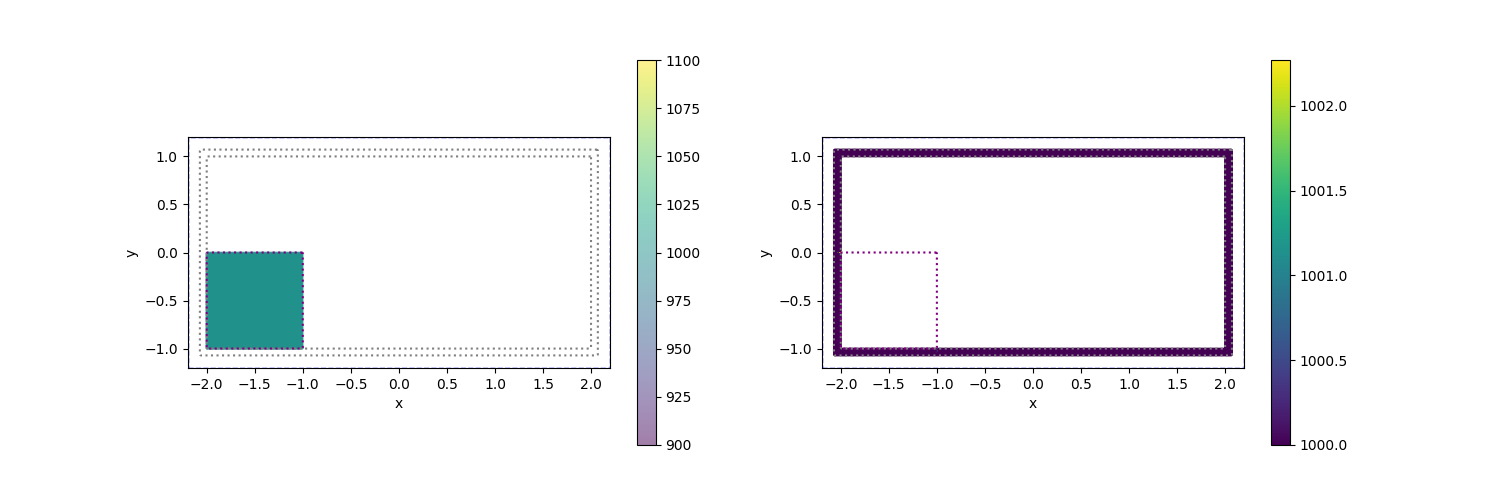

In [21]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])


visualizationState = prepVisualizationState(perennialState, config, grid = True)
boundaryParticlePositions = perennialState['boundary']['positions'] 
# axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = 'black', marker = 'x', s = 2)

boundaryGhostState = buildBoundaryGhostParticles(perennialState, config)
perennialState['boundaryGhost'] = boundaryGhostState
ghostParticlePositions = boundaryGhostState['positions']

boundaryDensity, shepardDensity = mDBCDensity(perennialState, config)

sc = axis[0,0].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), c = perennialState['fluid']['densities'].detach().cpu().numpy(), marker = 'x', s = 1, alpha = 0.5)

# sc = axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = boundaryGhostState['numNeighbors'], marker = 'o', s = 2)
# sc = axis[0,0].scatter(ghostParticlePositions[:,0].detach().cpu().numpy(), ghostParticlePositions[:,1].detach().cpu().numpy(), c = 'blue', marker = 'o', s = 2)
fig.colorbar(sc, ax = axis[0,0])
sc = axis[0,1].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = boundaryDensity.detach().cpu().numpy(), marker = 'x', s = 2)
# sc = axis[0,1].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = perennialState['boundary']['normals'][:,0].detach().cpu().numpy(), marker = 'x', s = 2)
fig.colorbar(sc, ax = axis[0,1])

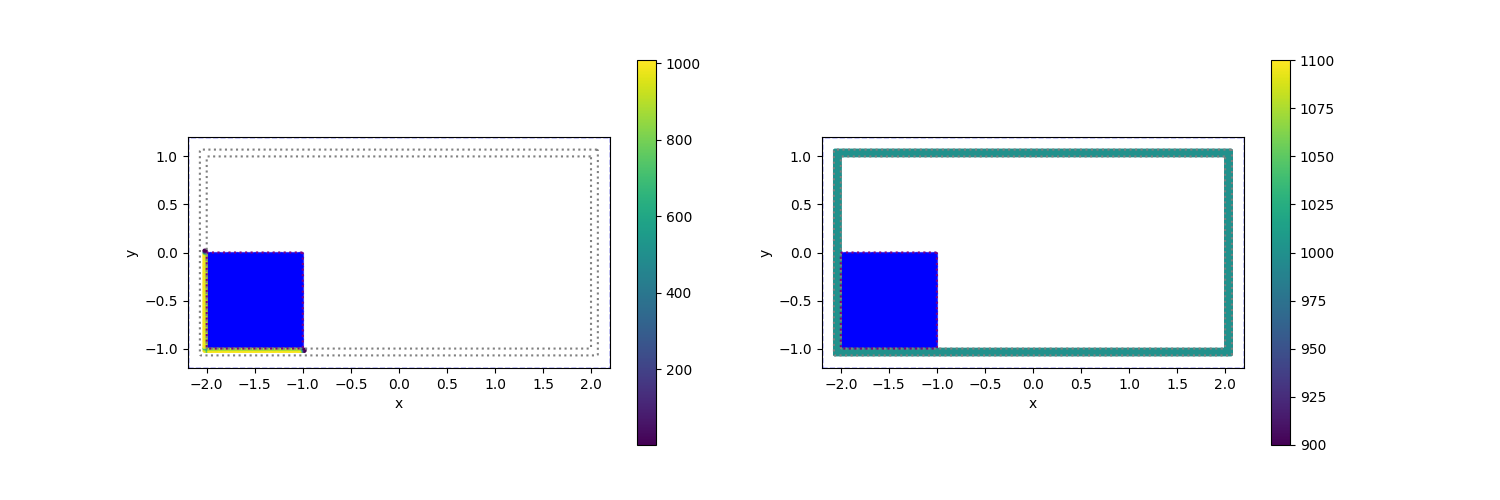

In [22]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])


visualizationState = prepVisualizationState(perennialState, config, grid = True)
boundaryParticlePositions = perennialState['boundary']['positions'] 
# axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = 'black', marker = 'x', s = 2)

boundaryGhostState = buildBoundaryGhostParticles(perennialState, config)
perennialState['boundaryGhost'] = boundaryGhostState
ghostParticlePositions = boundaryGhostState['positions']

boundaryDensity, shepardDensity = mDBCDensity(perennialState, config)

sc = axis[0,0].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'blue', marker = 'x', s = 2, alpha = 0.5)
sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'blue', marker = 'x', s = 2, alpha = 0.5)


numNeighbors = boundaryGhostState['numNeighbors']
threshold = 1


shepardNominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], None, operation = 'density', neighborhood = boundaryGhostState['neighborhood'])
shepardDenominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], 
        (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])),
        # (boundaryGhostState['densities'] / boundaryGhostState['masses'], perennialState['fluid']['densities'] / perennialState['fluid']['masses']),
            operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])

shepardDensity = shepardNominator / (shepardDenominator + 1e-7)

sc = axis[0,0].scatter(boundaryParticlePositions[numNeighbors >= threshold,0].detach().cpu().numpy(), boundaryParticlePositions[numNeighbors >= threshold,1].detach().cpu().numpy(), c = shepardNominator[numNeighbors >= threshold].detach().cpu().numpy(), marker = 'x', s = 2)

# sc = axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = boundaryGhostState['numNeighbors'], marker = 'o', s = 2)
# sc = axis[0,0].scatter(ghostParticlePositions[:,0].detach().cpu().numpy(), ghostParticlePositions[:,1].detach().cpu().numpy(), c = 'blue', marker = 'o', s = 2)
fig.colorbar(sc, ax = axis[0,0])
# sc = axis[0,1].scatter(boundaryParticlePositions[numNeighbors >= threshold,0].detach().cpu().numpy(), boundaryParticlePositions[numNeighbors >= threshold,1].detach().cpu().numpy(), c = shepardDensity[numNeighbors >= threshold].detach().cpu().numpy(), marker = 'x', s = 2)
sc = axis[0,1].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = perennialState['boundary']['densities'].detach().cpu().numpy(), marker = 'x', s = 2)
fig.colorbar(sc, ax = axis[0,1])

In [23]:
# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# setPlotBaseAttributes(axis[0,1], config)

# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])


# visualizationState = prepVisualizationState(perennialState, config, grid = True)
# boundaryParticlePositions = perennialState['boundary']['positions'] 
# # axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = 'black', marker = 'x', s = 2)

# boundaryGhostState = buildBoundaryGhostParticles(perennialState, config)
# perennialState['boundaryGhost'] = boundaryGhostState
# ghostParticlePositions = boundaryGhostState['positions']

# boundaryDensity, shepardDensity = mDBCDensity(perennialState, config)

# sc = axis[0,0].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'blue', marker = 'x', s = 2, alpha = 0.5)
# sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'blue', marker = 'x', s = 2, alpha = 0.5)


# numNeighbors = boundaryGhostState['numNeighbors']
# numNeighborsG = boundaryGhostState['numNeighbors']
# numNeighborsB = perennialState['fluidToBoundaryNeighborhood']['numNeighbors']
# threshold = 1


# shepardNominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], None, operation = 'density', neighborhood = boundaryGhostState['neighborhood'])
# shepardDenominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], 
#         (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])),
#         # (boundaryGhostState['densities'] / boundaryGhostState['masses'], perennialState['fluid']['densities'] / perennialState['fluid']['masses']),
#             operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])

# shepardDensity = shepardNominator / (shepardDenominator + 1e-7)

# sc = axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = torch.logical_and(numNeighborsG != 0, numNeighborsB == 0).detach().cpu().numpy(), marker = 'x', s = 2)

# # sc = axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = boundaryGhostState['numNeighbors'], marker = 'o', s = 2)
# # sc = axis[0,0].scatter(ghostParticlePositions[:,0].detach().cpu().numpy(), ghostParticlePositions[:,1].detach().cpu().numpy(), c = 'blue', marker = 'o', s = 2)
# fig.colorbar(sc, ax = axis[0,0])
# sc = axis[0,1].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = (numNeighborsB != 0).detach().cpu().numpy(), marker = 'x', s = 2)
# # sc = axis[0,1].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = perennialState['boundary']['normals'][:,0].detach().cpu().numpy(), marker = 'x', s = 2)
# fig.colorbar(sc, ax = axis[0,1])

In [24]:
from diffSPH.v2.modules.neighborhood import searchNeighbors

In [25]:
state = perennialState   
searchNeighbors(state, config)
# state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, priorNeighborhood = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'])
# _, state['fluid']['numNeighbors'] = countUniqueEntries(state['fluid']['neighborhood']['indices'][0], state['fluid']['positions'])

state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
state['outletGhost'] = buildOutletGhostParticles(regions, state, config)

# if config['boundary']['active']:
#     if not config['boundary']['static']:
#         state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, priorNeighborhood = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'])
#         _, state['boundary']['numNeighbors'] = countUniqueEntries(state['boundary']['neighborhood']['indices'][0], state['boundary']['positions'])
    
#     state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
#     _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
#     state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
#     _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])

if config['simulation']['densityScheme'] == 'summation':
    if config['boundary']['active']:
        state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
    else:
        state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')

state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)

In [26]:
display(config)

{'timestep': {'fixed': True,
  'dt': 0.0001,
  'active': True,
  'CFL': 1.5,
  'maxDt': 0.1,
  'minDt': 0.001,
  'viscosityConstraint': True,
  'accelerationConstraint': True,
  'acousticConstraint': True},
 'domain': {'adjustParticle': False,
  'adjustDomain': False,
  'dim': 2,
  'periodic': False,
  'minExtent': tensor([-2.2000, -1.2000]),
  'maxExtent': tensor([2.2000, 1.2000]),
  'periodicity': tensor([False, False])},
 'shifting': {'scheme': 'deltaSPH',
  'threshold': 0.05,
  'maxIterations': 1,
  'freeSurface': True,
  'R': 0.25,
  'n': 4,
  'CFL': 1.5,
  'computeMach': True,
  'solver': 'BiCGStab_wJacobi',
  'normalScheme': 'lambda',
  'projectionScheme': 'mat',
  'surfaceScaling': 0.1,
  'summationDensity': False,
  'useExtendedMask': False,
  'initialization': 'zero',
  'maxSolveIter': 64,
  'surfaceDetection': 'Barcasco',
  'active': True},
 'sps': {'active': False},
 'diffusion': {'velocityScheme': 'deltaSPH_inviscid',
  'delta': 0.1,
  'densityScheme': 'deltaSPH',
  'nu': 

In [27]:
# perennialState['boundary']

Text(0.5, 0.98, 'Time: 0.00 s, timestep: 0, dt: 1.00e-04 s, particles: 20633 (11449 fluid + 9184 boundary)')

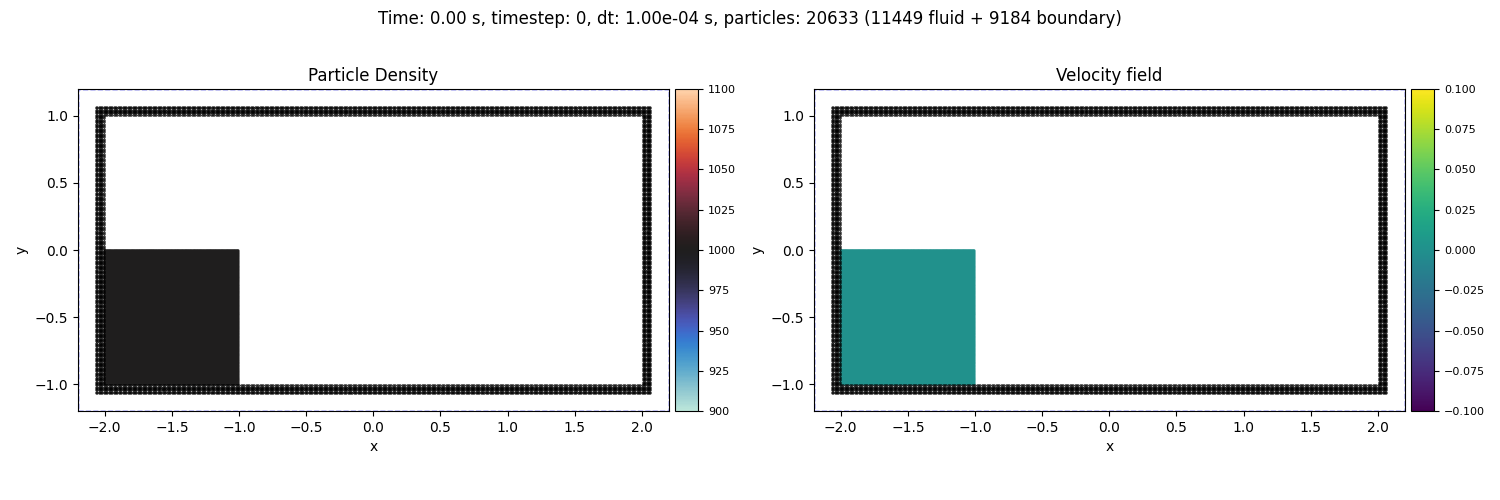

In [28]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
s = 1

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'densities', mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle Density', which = 'fluid', plotBoth = False, midPoint = config['fluid']['rho0'])
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field', plotBoth = False)


axis[0,0].scatter(
    perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), 
    perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
    c = 'black',
    marker = 'x',
    s = 1,
    alpha = 0.5)
axis[0,1].scatter(
    perennialState['boundary']['positions'][:,0].detach().cpu() .numpy(), 
    perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
    c = 'black',
    marker = 'x',
    s = 1,
    alpha = 0.5)

fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')

In [29]:

# computeKernels = False


# neighborDatastructure = getNeighborSearchDataStructure(perennialState['fluid'], config)
# neighborhood = neighborSearchExisting(perennialState['fluid']['positions'], perennialState['fluid']['supports'], neighborDatastructure, 'scatter', 1, 'cpp')
# pos_x = getPeriodicPosition(perennialState['fluid']['positions'], config)
# pos_y = getPeriodicPosition(perennialState['fluid']['positions'], config)

# neighborhood_actual, hij_actual, rij, xij = computeNeighborhood(neighborhood, pos_x, pos_y, config, mode)

# numNeighbors = countUniqueEntries(neighborhood_actual[0], pos_x)[1].to(torch.int32)
# neighborOffsets = torch.hstack((torch.tensor([0], dtype = torch.int32, device = numNeighbors.device), torch.cumsum(numNeighbors, dim = 0).to(torch.int32)))[:-1]\

# neighborDict = {
#     'indices': neighborhood_actual,
#     'fullIndices': neighborhood,
#     'distances': rij,
#     'vectors': xij,
#     'supports': hij_actual,
#     'initialPositions': (perennialState['fluid']['positions'], perennialState['fluid']['positions']),
#     'numNeighbors': numNeighbors,
#     'neighborOffsets': neighborOffsets,
# }

# if computeKernels:
#     dim = config['domain']['dim']
#     kernel = config['kernel']['function']
#     neighborDict['kernels'] = kernel.kernel(rij, hij_actual, dim)
#     neighborDict['gradients'] = kernel.kernelGradient(rij, xij, hij_actual, dim) 

In [29]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(8)):
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            # dx, _ = solveShifting(curState, config)
            # curState['fluid']['shiftAmount'] = dx
            # curState['fluid']['positions'] += dx

        
print(prof.key_averages().table(sort_by='self_cpu_time_total'))
# print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-06-06 12:47:49 90565:90565 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/8 [00:00<?, ?it/s]

[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2024-06-06 12:48:05 90565:90565 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-06 12:48:05 90565:90565 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::index        41.87%        6.508s        48.69%        7.569s       1.329ms       5.22 Gb       4.19 Gb          5696  
                                              aten::mul        11.85%        1.841s        12.07%        1.876s     270.754us       2.61 Gb       2.60 Gb          6928  
                                          aten::nonzero         6.71%        1.043s         6.73%        1.046s     838.104us       1.04 Gb       1.03

In [32]:
fluidDatastructure, neighborhood_fluid_to_fluid = neighborSearch(perennialState['fluid'], perennialState['fluid'], config, True, None, None, True)
boundaryDatastructure, neighborhood_boundary_to_boundary = neighborSearch(perennialState['boundary'], perennialState['boundary'], config, True, None, None, True)

_, neighborhood_boundary_to_fluid = neighborSearch(perennialState['boundary'], perennialState['fluid'], config, True, None, fluidDatastructure, True)
_, neighborhood_fluid_to_boundary = neighborSearch(perennialState['fluid'], perennialState['boundary'], config, True, None, boundaryDatastructure, True)


Building Datastructure because prior state is None
Updating Neighborsearch because priorState is None
Building Datastructure because prior state is None
Updating Neighborsearch because priorState is None
Updating Neighborsearch because priorState is None
Updating Neighborsearch because priorState is None


In [33]:
print(neighborhood_boundary_to_fluid['indices'][0].max(), neighborhood_boundary_to_fluid['indices'][1].max())

tensor(4626) tensor(11344)


In [34]:
perennialState['fluid']['numParticles']

11449

In [35]:
perennialState['boundary']['numParticles']

9184

In [39]:

def simulationStep(state, config):
    print(state['fluid'].keys())
    print('fluid - fluid neighbor search')
    state['fluid']['datastructure'], state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, 
        computeKernels = True, 
        priorState = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'],
        neighborDatastructure = None if 'datastructure' not in state['fluid'] else state['fluid']['datastructure'],
        verbose = True)
    torch.cuda.synchronize()
    if config['boundary']['active']:
        print('boundary - boundary neighbor search')
        state['boundary']['datastructure'], state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, 
            computeKernels = True, 
            priorState = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'],
            neighborDatastructure = None if 'datastructure' not in state['boundary'] else state['boundary']['datastructure'],
            verbose = True)
    torch.cuda.synchronize()

    if config['boundary']['active']:
        print('boundary - fluid neighbor search')
        _, state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, True, 
            None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'], 
            state['fluid']['datastructure'], True)
        print('fluid - boundary neighbor search')
        _, state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, True, None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'], state['boundary']['datastructure'], True)
        print('boundary - fluid neighbor search count')
        # state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
        _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])


        print('fluid - boundary neighbor search couunt')
        # state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
        _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])

    # state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, priorNeighborhood = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'])
    _, state['fluid']['numNeighbors'] = countUniqueEntries(state['fluid']['neighborhood']['indices'][0], state['fluid']['positions'])
    torch.cuda.synchronize()

    print('ghost particles')
    state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
    state['outletGhost'] = buildOutletGhostParticles(regions, state, config)
    torch.cuda.synchronize()
    if config['boundary']['active']:
        if not config['boundary']['static']:
            # state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, priorNeighborhood = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'])
            _, state['boundary']['numNeighbors'] = countUniqueEntries(state['boundary']['neighborhood']['indices'][0], state['boundary']['positions'])
        
        # state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
        # _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
        # state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
        # _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])
    torch.cuda.synchronize()
    if config['simulation']['densityScheme'] == 'summation':
        if config['boundary']['active']:
            state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
        else:
            state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
    torch.cuda.synchronize()
    state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
    if state['outletGhost'] is not None:
        ghostState = state['outletGhost']
        neighbors = ghostState['neighborhood']['indices'][0]
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

        cond = torch.logical_and(ghostState['numNeighbors'] >= 10, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
        cond = ghostState['numNeighbors'] >= 10

        def updateQuantity(state, ghostState, quantity, solution, cond):
            return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
        state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
        
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
        state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

        
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
        state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)
        


        # state['outletGhost']['velocities'][:,0] = LiuLiuConsistent(state['outletGhost'], state['fluid'], state['fluid']['velocities'][:,0])[0]
        # state['outletGhost']['velocities'][:,0] = LiuLiuConsistent(state['outletGhost'], state['fluid'], state['fluid']['velocities'][:,0])[0]
    torch.cuda.synchronize()

    # with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
    state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
    # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluid')
    state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])
    torch.cuda.synchronize()
    state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')

    state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]
    # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
    torch.cuda.synchronize()
    state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
    # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

    # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
    torch.cuda.synchronize()
    if config['boundary']['active']:
        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')

        state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
    else:
        state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')

        state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
    torch.cuda.synchronize()
    state['fluid']['pressures'] = computeEOS(state['fluid'], config)

    if 'boundary' in state:
        state['boundary']['pressures'] = computeEOS(state['boundary'], config)

        state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
    else:
        state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
    torch.cuda.synchronize()
    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')
    state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)


    #         if config['SPS']['active']:
    #             with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #                 simulationState['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
    torch.cuda.synchronize()
    dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
    drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

    if state['outletGhost'] is not None:
        dudt[ghostState['fluidIndex']] = 0
        drhodt[ghostState['fluidIndex']] = 0

    if 'boundary' not in state:
        return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
    torch.cuda.synchronize()   
    boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
    boundary_drhodt = state['boundary']['momentumEquation'] *0

    return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]


from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    # for i in tqdm(range(8)):
        # with record_function("timing"): 
curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            # dx, _ = solveShifting(curState, config)
            # curState['fluid']['shiftAmount'] = dx
            # curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
# print(prof.key_averages().table(sort_by='cpu_time_total'))


# prof.export_chrome_trace("trace.json")

dict_keys(['numParticles', 'positions', 'areas', 'pressures', 'divergence', 'masses', 'supports', 'index', 'densities', 'velocities', 'accelerations', 'distances', 'numNeighbors', 'neighborhood', 'normals'])
fluid - fluid neighbor search
Building Datastructure because prior state is None
boundary - boundary neighbor search
Building Datastructure because prior state is None
boundary - fluid neighbor search
Updating Neighborsearch because priorState is None
fluid - boundary neighbor search
Updating Neighborsearch because priorState is None
boundary - fluid neighbor search count
fluid - boundary neighbor search couunt
ghost particles
Updating Neighborsearch because priorState is None
dict_keys(['numParticles', 'positions', 'areas', 'pressures', 'divergence', 'masses', 'supports', 'index', 'densities', 'velocities', 'accelerations', 'distances', 'numNeighbors', 'normals', 'neighborhood', 'datastructure'])
fluid - fluid neighbor search
boundary - boundary neighbor search
boundary - fluid ne

In [37]:
curState

{'fluid': {'numParticles': 11449,
  'positions': tensor([[-1.9988, -0.9985],
          [-1.9894, -0.9985],
          [-1.9799, -0.9985],
          ...,
          [-1.0251, -0.0047],
          [-1.0158, -0.0047],
          [-1.0064, -0.0047]]),
  'areas': tensor([8.7891e-05, 8.7891e-05, 8.7891e-05,  ..., 8.7891e-05, 8.7891e-05,
          8.7891e-05]),
  'pressures': tensor([2.9802, 4.1723, 4.1723,  ..., 0.0000, 0.0000, 0.0000]),
  'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'masses': tensor([0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879]),
  'supports': tensor([0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356]),
  'index': tensor([    0,     1,     2,  ..., 11446, 11447, 11448]),
  'densities': tensor([1000.0012, 1000.0016, 1000.0018,  ..., 1000.0000, 1000.0000,
          1000.0000]),
  'velocities': tensor([[ 1.4461e-05, -9.4680e-04],
          [-2.7726e-06, -9.4500e-04],
          [ 1.9998e-06, -9.4405e-04],
          ...,
          [ 0.0000e+00, -9.8100e-04],
 

In [33]:
# from diffSPH.v2.math import mod

# @torch.compile
# def moduloDistance(x, y, minD, maxD, periodicity):        
#     xij = x - y

#     xij = torch.stack([xij[i] if not periodic_i else mod(xij[i], minD[i], maxD[i]) for i, periodic_i in enumerate(periodicity)], dim = -1)
#     # rij = torch.sqrt((xij**2).sum(-1))
#     rij = torch.linalg.norm(xij, dim = -1)
#     xij = xij / (rij + 1e-7).view(-1,1)

#     return xij, rij


# torch.vmap(moduloDistance, (0,0,None,None,None))(pos_x[neighborhood[0],:], pos_y[neighborhood[1],:], config['domain']['minExtent'], config['domain']['maxExtent'], config['domain']['periodicity'])

In [39]:
# %%timeit 
# torch.vmap(moduloDistance, (0,0,None,None,None))(pos_x[neighborhood[0],:], pos_y[neighborhood[1],:], config['domain']['minExtent'], config['domain']['maxExtent'], config['domain']['periodicity'])

In [40]:
# %%timeit 

# xij = pos_x[neighborhood[0],:] - pos_y[neighborhood[1],:]
# xij = torch.stack([xij[:,i] if not periodic_i else mod(xij[:,i], config['domain']['minExtent'][i], config['domain']['maxExtent'][i]) for i, periodic_i in enumerate(config['domain']['periodicity'])], dim = -1)
# # rij = torch.sqrt((xij**2).sum(-1))
# rij = torch.linalg.norm(xij, dim = -1)
# xij = xij / (rij + 1e-7).view(-1,1)

In [41]:
# i,j = neighborSearchExisting(perennialState['fluid']['positions'], perennialState['fluid']['supports'], neighborDatastructure, 'scatter', 1, 'cpp')

In [42]:
# i_, j_ = radiusSearch(perennialState['fluid']['positions'],perennialState['fluid']['positions'], (perennialState['fluid']['supports'], perennialState['fluid']['supports']), None, 
#                       'scatter',
#                       config['domain']['minExtent'], config['domain']['maxExtent'], config['domain']['periodic'], 
#                       perennialState['fluid']['positions'].shape[0],'compact',  False, False)

In [43]:
# print(j)
# print(j_)
# print(torch.all(j == j_))

In [44]:
config['diffusion']['alpha'] = 0.01

In [31]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
priorState = None
for i in tqdm(range(30000)):
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'] += dx
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 100 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'densities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)

    for emitter in regions:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)
        if emitter['type'] == 'forcing':
            processForcing(emitter, config, perennialState)


  0%|          | 0/30000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x57d4bb6a7e80] Dupped color: FF666666
[Parsed_palettegen_2 @ 0x57d4bb6a7e80] Dupped color: FFFEFFFD


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_06_04-10_37_16/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_06_04-10_37_16.gif'], returncode=0)

In [334]:
config["simulation"]["timestamp"]

'2024_06_03-12_59_59'

In [1]:
print("/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i *.png -c:v libx264 -b:v 20M -r 30 'output.mp4")

/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i *.png -c:v libx264 -b:v 20M -r 30 'output.mp4


In [23]:
fluidDatastructure, neighborhood_fluid_to_fluid = neighborSearch(perennialState['fluid'], perennialState['fluid'], config, True, None, None, True)
boundaryDatastructure, neighborhood_boundary_to_boundary = neighborSearch(perennialState['boundary'], perennialState['boundary'], config, True, None, None, True)

_, neighborhood_boundary_to_fluid = neighborSearch(perennialState['boundary'], perennialState['fluid'], config, True, None, fluidDatastructure, True)
_, neighborhood_fluid_to_boundary = neighborSearch(perennialState['fluid'], perennialState['boundary'], config, True, None, boundaryDatastructure, True)

# def neighborSearch(queryState, referenceState, config, computeKernels = True, priorState = None, neighborDatastructure = None, verbose = False):

TypeError: neighborSearch() takes from 3 to 5 positional arguments but 7 were given

In [ ]:

def simulationStep(state, config):
    print('fluid - fluid neighbor search')
    state['fluid']['datastructure'], state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, 
        computeKernels = True, 
        priorState = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'],
        neighborDatastructure = None if 'datastructure' not in state['fluid'] else state['fluid']['datastructure'],
        verbose = True)
    torch.cuda.synchronize()
    if config['boundary']['active']:
        print('boundary - boundary neighbor search')
        state['boundary']['datastructure'], state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, 
            computeKernels = True, 
            priorState = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'],
            neighborDatastructure = None if 'datastructure' not in state['fluid'] else state['fluid']['datastructure'],
            verbose = True)
    torch.cuda.synchronize()

    if config['boundary']['active']:
        print('boundary - fluid neighbor search')
        _, state['boundaryToFluidNeighborhood'] = neighborSearch(perennialState['boundary'], perennialState['fluid'], config, True, None, state['fluid']['datastructure'], True)
        print('fluid - boundary neighbor search')
        _, state['fluidToBoundaryNeighborhood'] = neighborSearch(perennialState['fluid'], perennialState['boundary'], config, True, None, state['boundary']['datastructure'], True)
        # state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
        _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
        # state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
        _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])

    # state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, priorNeighborhood = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'])
    _, state['fluid']['numNeighbors'] = countUniqueEntries(state['fluid']['neighborhood']['indices'][0], state['fluid']['positions'])
    torch.cuda.synchronize()
    state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
    state['outletGhost'] = buildOutletGhostParticles(regions, state, config)
    torch.cuda.synchronize()
    if config['boundary']['active']:
        if not config['boundary']['static']:
            # state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, priorNeighborhood = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'])
            _, state['boundary']['numNeighbors'] = countUniqueEntries(state['boundary']['neighborhood']['indices'][0], state['boundary']['positions'])
        
        # state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
        # _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
        # state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
        # _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])
    torch.cuda.synchronize()
    if config['simulation']['densityScheme'] == 'summation':
        if config['boundary']['active']:
            state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
        else:
            state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
    torch.cuda.synchronize()
    state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
    if state['outletGhost'] is not None:
        ghostState = state['outletGhost']
        neighbors = ghostState['neighborhood']['indices'][0]
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

        cond = torch.logical_and(ghostState['numNeighbors'] >= 10, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
        cond = ghostState['numNeighbors'] >= 10

        def updateQuantity(state, ghostState, quantity, solution, cond):
            return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
        state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
        
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
        state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

        
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
        state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)
        


        # state['outletGhost']['velocities'][:,0] = LiuLiuConsistent(state['outletGhost'], state['fluid'], state['fluid']['velocities'][:,0])[0]
        # state['outletGhost']['velocities'][:,0] = LiuLiuConsistent(state['outletGhost'], state['fluid'], state['fluid']['velocities'][:,0])[0]
    torch.cuda.synchronize()

    # with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
    state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
    # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluid')
    state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])
    torch.cuda.synchronize()
    state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')

    state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]
    # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
    torch.cuda.synchronize()
    state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
    # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

    # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
    torch.cuda.synchronize()
    if config['boundary']['active']:
        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')

        state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
    else:
        state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')

        state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
    torch.cuda.synchronize()
    state['fluid']['pressures'] = computeEOS(state['fluid'], config)

    if 'boundary' in state:
        state['boundary']['pressures'] = computeEOS(state['boundary'], config)

        state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
    else:
        state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
    torch.cuda.synchronize()
    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')
    state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)


    #         if config['SPS']['active']:
    #             with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #                 simulationState['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
    torch.cuda.synchronize()
    dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
    drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

    if state['outletGhost'] is not None:
        dudt[ghostState['fluidIndex']] = 0
        drhodt[ghostState['fluidIndex']] = 0

    if 'boundary' not in state:
        return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
    torch.cuda.synchronize()   
    boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
    boundary_drhodt = state['boundary']['momentumEquation'] *0

    return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]



In [ ]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(8)):
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            # dx, _ = solveShifting(curState, config)
            # curState['fluid']['shiftAmount'] = dx
            # curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-06-05 15:24:51 60006:60006 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/8 [00:00<?, ?it/s]

[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


fluid - fluid neighbor search
Building Datastructure because prior state is None
boundary - boundary neighbor search
boundary - fluid neighbor search
Updating Neighborsearch because priorState is None
fluid - boundary neighbor search
Updating Datastructure because of shape mismatch (torch.Size([11449, 2]) != torch.Size([9184, 2]))
Updating Neighborsearch because priorState is None


STAGE:2024-06-05 15:24:51 60006:60006 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-05 15:24:51 60006:60006 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/winchenbach/dev/diffSPH/src/diffSPH/v2/util.py", line 18, in countUniqueEntries
    ii, nit = torch.unique(indices, return_counts=True)
    ni = torch.zeros(positions.shape[0], dtype=nit.dtype, device=positions.device)
    ni[ii] = nit
    ~~~~~~~~~~~~ <--- HERE
    return ii, ni
RuntimeError: index 9202 is out of bounds for dimension 0 with size 9184


In [ ]:

print(prof.key_averages().table(sort_by='cpu_time_total'))

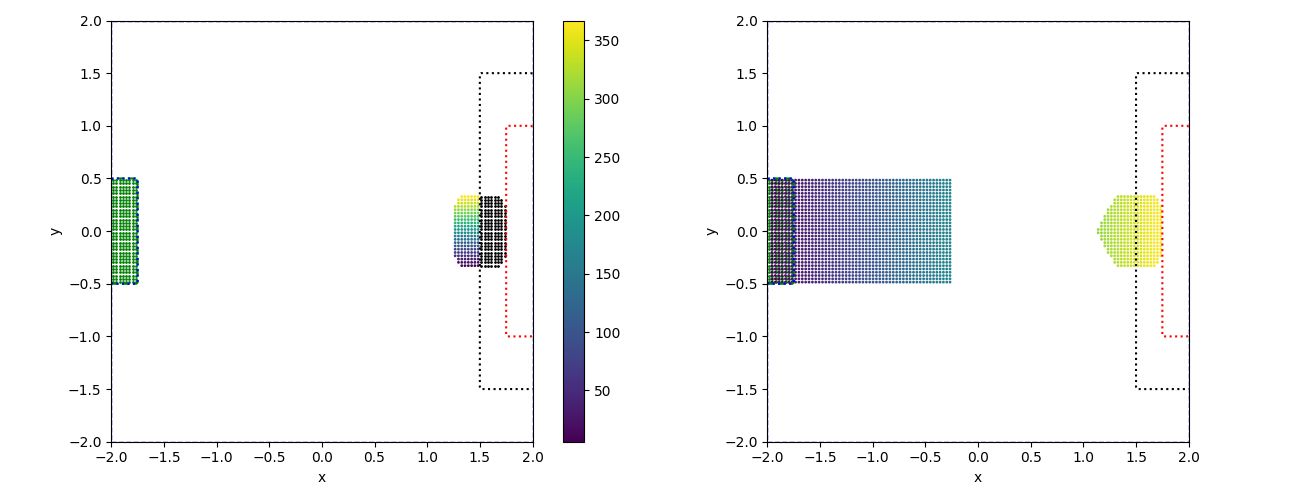

In [ ]:
from diffSPH.v2.plotting import setPlotBaseAttributes

fig, axis = plt.subplots(1, 2, figsize = (13,5), squeeze = False)

setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])
fig.tight_layout()


ghostState = buildOutletGhostParticles(regions, perennialState, config)

if ghostState is not None:

    sc = axis[0,0].scatter(ghostState['positions'][:,0].detach().cpu().numpy(), ghostState['positions'][:,1].detach().cpu().numpy(), s = 1, c = ghostState['fluidIndex'])
    fig.colorbar(sc, ax = axis[0,0])

    ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]

    # axis[0,0].quiver(pos[:,0].detach().cpu().numpy(), pos[:,1].detach().cpu().numpy(), grad[:,0].detach().cpu().numpy(), grad[:,1].detach().cpu().numpy(), color = 'black', scale = 10)

    sc = axis[0,0].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = 'black')

q = perennialState['fluid']['positions'][:,0]# * perennialState['fluid']['positions'][:,1]


sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = q)


In [ ]:
# qfn = lambda x: x[:,0] + x[:,1]

# q = qfn(fluidState['positions'])# + fluidState['positions'][:,1]
# solution, M, b = LiuLiuConsistent(ghostState, fluidState, q)
# print(f'solution: {solution.shape}, min: {solution.min()}, max: {solution.max()}')

# extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:])
# print(f'extrapolated: {extrapolated.shape}, min: {extrapolated.min()}, max: {extrapolated.max()}')

# ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]
# gt = qfn(ghostPos)

# error = extrapolated - gt
# print(f'error: {error.shape}, min: {error.min()}, max: {error.max()}, mean: {error.mean()}')


solution: torch.Size([168, 3]), min: 0.9999753832817078, max: 1.8124845027923584
extrapolated: torch.Size([168]), min: 1.1875139474868774, max: 2.0000178813934326
error: torch.Size([168]), min: -5.4836273193359375e-06, max: 3.2186508178710938e-06, mean: 2.0790668031622772e-07


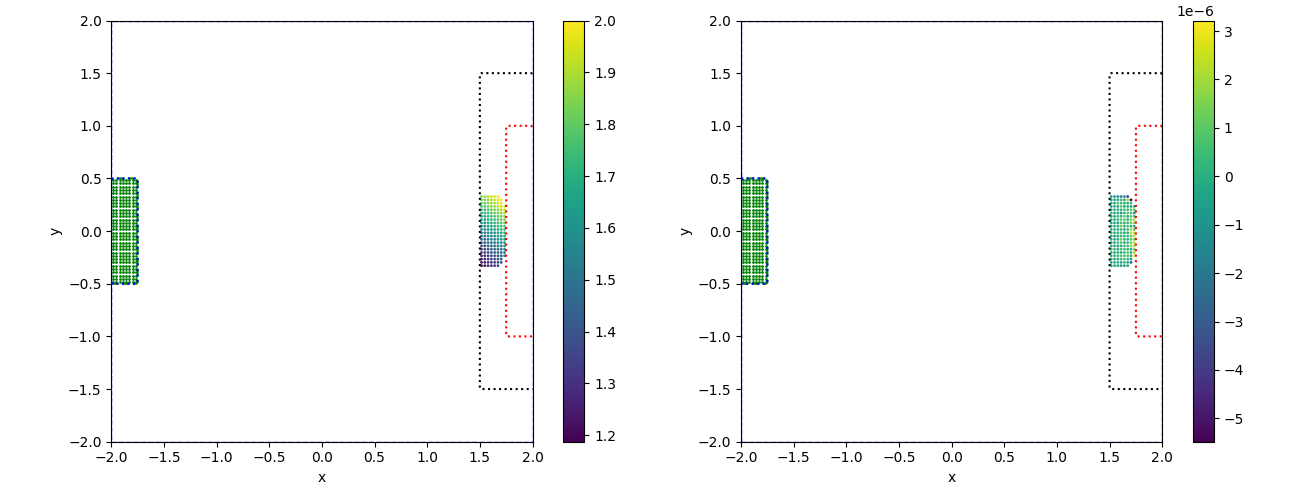

In [ ]:
from diffSPH.v2.plotting import setPlotBaseAttributes

qfn = lambda x: x[:,0] + x[:,1]

q = qfn(fluidState['positions'])# + fluidState['positions'][:,1]
if ghostState is not None:
    solution, M, b = LiuLiuConsistent(ghostState, fluidState, q)
    print(f'solution: {solution.shape}, min: {solution.min()}, max: {solution.max()}')

    extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:])
    print(f'extrapolated: {extrapolated.shape}, min: {extrapolated.min()}, max: {extrapolated.max()}')

    ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]
    gt = qfn(ghostPos)

    error = extrapolated - gt
    print(f'error: {error.shape}, min: {error.min()}, max: {error.max()}, mean: {error.mean()}')


fig, axis = plt.subplots(1, 2, figsize = (13,5), squeeze = False)

setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])
fig.tight_layout()


ghostState = buildOutletGhostParticles(regions, perennialState, config)

if ghostState is not None:

    # sc = axis[0,0].scatter(ghostState['positions'][:,0].detach().cpu().numpy(), ghostState['positions'][:,1].detach().cpu().numpy(), s = 1, c = b[:,0])
    # fig.colorbar(sc, ax = axis[0,0])

    # ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]

    # axis[0,0].quiver(pos[:,0].detach().cpu().numpy(), pos[:,1].detach().cpu().numpy(), grad[:,0].detach().cpu().numpy(), grad[:,1].detach().cpu().numpy(), color = 'black', scale = 10)

    sc = axis[0,0].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = extrapolated)
    fig.colorbar(sc, ax = axis[0,0])

    q = perennialState['fluid']['positions'][:,0]# * perennialState['fluid']['positions'][:,1]


    sc = axis[0,1].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = extrapolated - gt)
    fig.colorbar(sc, ax = axis[0,1])
# sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = q)


In [ ]:

for i in tqdm(range(1500)):
    # perennialState = simulationStep(perennialState, config)
    perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 50 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'index')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()

    for emitter in regions:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)

    # emitterNeighborhood = neighborSearch(emitterPositions, perennialState['fluid'], config, computeKernels=False)

    # distance = emitterNeighborhood['distances']
    # i = emitterNeighborhood['indices'][0]
    # newDistance = distance.new_ones(emitterPositions['numParticles'], dtype = config['compute']['dtype']) #* config['particle']['support']
    # minDistance = newDistance.index_reduce_(dim = 0, index = i, source = distance, include_self = False, reduce = 'amin')

    # emitterMask = minDistance >= config['particle']['dx'] / config['particle']['support']

    # newPositions = emitterPositions['positions'][emitterMask].to(config['compute']['device'])
    # newParticleState = {
    #     'numParticles': newPositions.shape[0],
    #     'positions': newPositions,

    #     'areas': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'],
    #     'masses': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'] * config['fluid']['rho0'],
    #     'densities': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['fluid']['rho0'],
    #     'supports': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['support'],

    #     'pressures': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'divergence': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),

    #     'velocities': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'accelerations': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'index': torch.arange(newPositions.shape[0], dtype = torch.int32, device = config['compute']['device']) + perennialState['uidCounter'],
    #     # 'neighbors': None,
    # }
    # newParticleState['velocities'][:,0] = u
    # # print(f'Adding {newParticleState["numParticles"]} particles (total {perennialState["fluid"]["numParticles"] + newParticleState["numParticles"]})')
    # perennialState['uidCounter'] += newParticleState['numParticles']

    # perennialState['fluid'] = mergeStates(perennialState['fluid'], newParticleState)


# visualizationState = prepVisualizationState(perennialState, config)
# updatePlot(indexPlot, visualizationState, 'index')
# updatePlot(quantPlot, visualizationState, 'densities')

  0%|          | 0/1500 [00:00<?, ?it/s]

Outlet: 2 particles removed
Current particles: 2032
torch.Size([2030]) tensor([   0,    1,    2,  ..., 2029, 2030, 2031])
Outlet: 6 particles removed
Current particles: 2062
torch.Size([2056]) tensor([   0,    1,    2,  ..., 2059, 2060, 2061])
Outlet: 10 particles removed
Current particles: 2088
torch.Size([2078]) tensor([   0,    1,    2,  ..., 2085, 2086, 2087])
Outlet: 14 particles removed
Current particles: 2110
torch.Size([2096]) tensor([   0,    1,    2,  ..., 2107, 2108, 2109])


In [ ]:
emitterPositions

{'numParticles': 1560,
 'positions': tensor([[-0.1953, -0.3203],
         [-0.1797, -0.3203],
         [-0.1641, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1557, 1558, 1559], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accele

In [ ]:
config['particle']

{'nx': 128,
 'dx': tensor(0.0156, device='cuda:0'),
 'support': tensor(0.0593, device='cuda:0'),
 'defaultVolume': tensor(0.0002, device='cuda:0'),
 'defaultSupport': tensor(0.0593, device='cuda:0'),
 'volume': tensor(0.0002, device='cuda:0'),
 'smoothingLength': tensor(0.0312, device='cuda:0')}

1560 1434


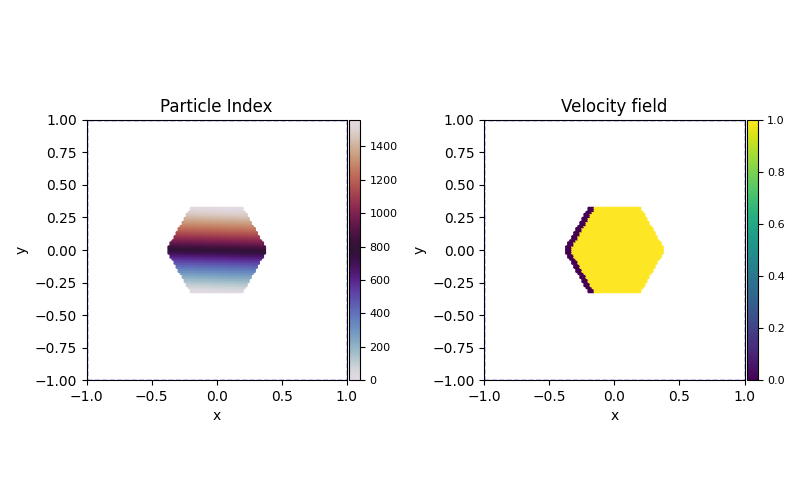

In [ ]:
fig, axis = plt.subplots(1,2, figsize = (8,5), squeeze = False)

s = 2
emitterState = {
    'fluid': copy.deepcopy(emitterPositions),
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

u = 1
perennialState['fluid']['velocities'][:,0] = u

visualizationState = prepVisualizationState(emitterState, config)

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = emitterMask, mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field')

fig.tight_layout()

{'numParticles': 7296,
 'positions': tensor([[-0.1453, -0.3203],
         [-0.1297, -0.3203],
         [-0.1141, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1431, 1432, 1433], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]], device='cuda:0'),
 'accele

In [ ]:
emitterPositions

{'numParticles': 1560,
 'positions': tensor([[-0.1953, -0.3203],
         [-0.1797, -0.3203],
         [-0.1641, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1557, 1558, 1559], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accele

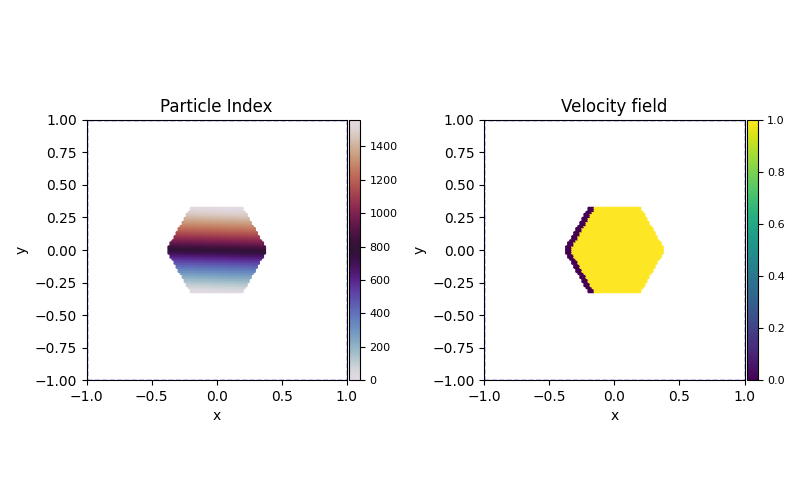

In [ ]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

particleState, mask = sampleParticles(config, sdfs = [sdf])

priorState = None
# particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
# particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])
particleState['velocities'][:,0] =  1 
particleState['velocities'][:,1] = 0

u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()

# perennialState = {
#     'fluid': copy.deepcopy(particleState),
#     'time': 0.0,
#     'timestep': 0,
#     'dt': config['timestep']['dt'],
# }
# del particleState['neighborhood']


In [ ]:
# from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid, visualizeParticleQuantity

# s = 2

# fig, axis = plt.subplot_mosaic('''AB''', figsize=(10.5,5), sharex = False, sharey = False)

# visualizationState = prepVisualizationState(perennialState, config)

# visualizeParticleQuantity(fig, axis['A'], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
#                           scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
# visualizeParticleQuantity(fig, axis['B'], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = True, operation = None, title = 'Velocity field')

# E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
# E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
# nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
# Re = u_mag * 2 / nu_total

# fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

# fig.tight_layout()

In [ ]:
# torch.cuda.memory._record_memory_history(max_entries=100000)

Setting up initial plot
Computing visualization state
Setting up plot A
Setting up plot B
Done setting up initial plot


0.0000%|          | 0/1 [00:00<?] ?it/s

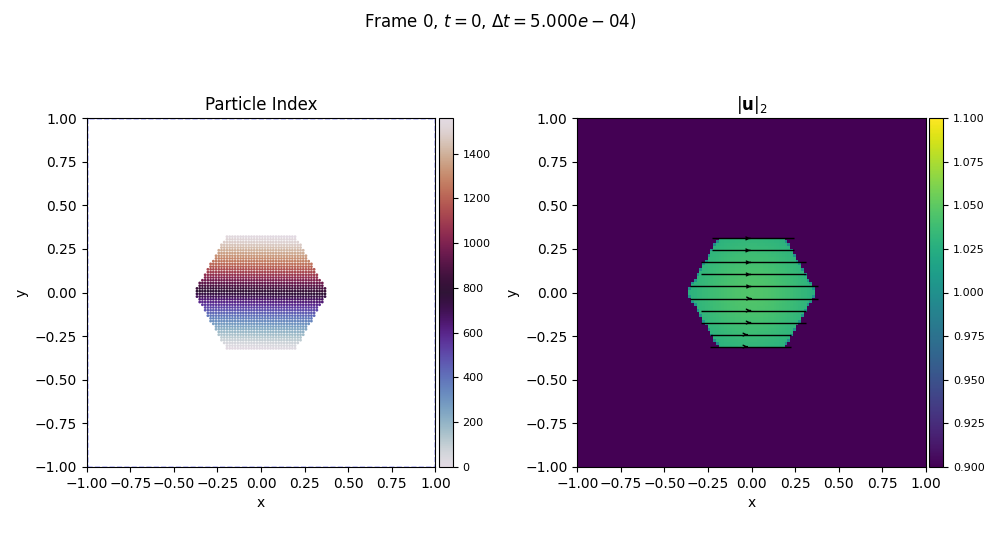

In [ ]:
from diffSPH.v2.plotting import updatePlots
from diffSPH.v2.runner import runSimulation, setupSimulation

def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    pass
    # E_k = perennialState['fluid']['E_k']
    # nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    # Re = u_mag * 2 / nu_total
    # title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

config['timestep']['active'] = False
config['timestep']['dt'] = 5e-4
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

perennialState, fig, axis, plotStates, priorState, pbar, stats = setupSimulation(initialState, config, stepLimit = -1, timeLimit = 1)

# E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
# E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
# nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
# Re = u_mag * 2 / nu_total

# title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')
fig.tight_layout()

# updatePlots(perennialState, particleState, config, plotStates, fig, axis)

In [ ]:

stat, pstate = runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = -1, timeLimit = 1, callBack = None)
# 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x795dc6e18b50>>
Traceback (most recent call last):
  File "/home/winchenbach/anaconda3/envs/torch_22/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# torch.cuda.memory._dump_snapshot('dump.pth')

In [ ]:
config['shifting']

{'scheme': 'deltaSPH',
 'threshold': 0.05,
 'maxIterations': 1,
 'freeSurface': False,
 'R': 0.25,
 'n': 4,
 'CFL': 1.5,
 'computeMach': True,
 'solver': 'BiCGStab_wJacobi',
 'normalScheme': 'lambda',
 'projectionScheme': 'mat',
 'surfaceScaling': 0.1,
 'summationDensity': False,
 'useExtendedMask': False,
 'initialization': 'zero',
 'maxSolveIter': 64,
 'surfaceDetection': 'Barcasco',
 'active': True}

In [ ]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(32)):
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            dx, _ = solveShifting(curState, config)
            curState['fluid']['shiftAmount'] = dx
            curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-05-22 11:06:28 1367417:1367417 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/32 [00:00<?, ?it/s]

STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:

print(prof.key_averages().table(sort_by='cuda_time_total'))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:
def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    perennialState['fluid']['E_k']
    nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    Re = u_mag * 2 / nu_total
    title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

    

def runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = 1000, timeLimit = -1, callBack = None):
    # for i in tqdm(range(1000)):
    frameStatistics = computeStatistics(perennialState, particleState, config)
    stats.append(frameStatistics)
    if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
        updatePlots(perennialState, particleState, config, plotStates, fig, axis)
    if config['export']['active']:
        f, simulationDataGroup = createOutputFile(config)
        
    lastUpdate = perennialState['time']
    while(True):
        perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
        # Particle shifting
        dx, _ = solveShifting(perennialState, config)
        perennialState['fluid']['shiftAmount'] = dx
        perennialState['fluid']['positions'] += dx
        # Frame done, update state for next timestep
        perennialState['dt'] = config['timestep']['dt']
        perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
        perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
        frameStatistics = computeStatistics(perennialState, particleState, config)
        
        if config['export']['active']:
            if perennialState['timestep'] % config['export']['interval'] == 0:
                writeFrame(simulationDataGroup, perennialState, priorState, frameStatistics, config)

        
        perennialState['time'] += config['timestep']['dt']
        perennialState['timestep'] += 1

        config['timestep']['dt'] = computeTimestep(perennialState, config)
        time = perennialState['time']
        dt = config['timestep']['dt']

        if timeLimit > 0:
            pbar.n = time.detach().cpu().item() if isinstance(time, torch.Tensor) else time
            pbar.refresh()
        else: 
            pbar.n = perennialState['timestep']
            pbar.refresh()
        if perennialState['time'] > timeLimit and timeLimit > 0:
            break
        if perennialState['timestep'] > stepLimit and stepLimit > 0:
            break



        ttime = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
        stats.append(frameStatistics)

        if callBack is not None:
            callBack(perennialState, particleState, config, plotStates, fig, axis, frameStatistics)
        if config['plot']['fps'] > 0:
            if perennialState['time'] > lastUpdate + 1 / config['plot']['fps']:
                lastUpdate = ttime
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)
        else:
            if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)

    pbar.close()
    if config['export']['active']:
        f.close()

    postProcessPlot(config)
    return stats, perennialState